In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
base_path = 'dataset_nyc_taxi_samples/parquet/'

## Yellow taxi

In [3]:
train_df_yellow = pd.read_parquet(base_path + 'yellow_train_1M.parquet')
train_df_yellow = train_df_yellow.sort_values(by="tpep_pickup_datetime")
train_df_yellow.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
31331         2  2019-02-01 00:00:53   2019-02-01 00:06:28              1.0   
6304          2  2019-02-01 00:01:07   2019-02-01 00:18:10              1.0   
32473         2  2019-02-01 00:03:25   2019-02-01 00:40:39              1.0   
24035         2  2019-02-01 00:04:58   2019-02-01 00:22:38              1.0   
7479          2  2019-02-01 00:06:38   2019-02-01 00:35:42              1.0   

       trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
31331           1.18         1.0                  N           230   
6304            1.86         1.0                  N           186   
32473          16.06         1.0                  N           100   
24035           3.41         1.0                  N           230   
7479           22.07         1.0                  N           132   

       DOLocationID  payment_type  ...  dew_point_2m (°C)  \
31331            50             1  ...              -24.6   
6304            162             1  ...              -24.6   
32473           174             1  ...              -24.6   
24035           145             1  ...              -24.6   
7479             66             1  ...              -24.6   

       apparent_temperature (°C)  precipitation (mm)  rain (mm)  \
31331                      -16.1                 0.0        0.0   
6304                       -16.1                 0.0        0.0   
32473                      -16.1                 0.0        0.0   
24035                      -16.1                 0.0        0.0   
7479                       -16.1                 0.0        0.0   

       snowfall (cm)  snow_depth (m)  surface_pressure (hPa)  cloud_cover (%)  \
31331            0.0            0.01                  1023.6                0   
6304             0.0            0.01                  1023.6                0   
32473            0.0            0.01                  1023.6                0   
24035            0.0            0.01                  1023.6                0   
7479             0.0            0.01                  1023.6                0   

       wind_speed_10m (km/h)  is_day ()  
31331                   12.1          0  
6304                    12.1          0  
32473                   12.1          0  
24035                   12.1          0  
7479                    12.1          0  

[5 rows x 32 columns]

In [4]:
train_df_yellow.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'retail_price',
       'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'snowfall (cm)', 'snow_depth (m)', 'surface_pressure (hPa)',
       'cloud_cover (%)', 'wind_speed_10m (km/h)', 'is_day ()'],
      dtype='object')

### Outliers & Resampling

In [5]:
train_df_yellow.set_index('tpep_pickup_datetime', inplace=True)

In [6]:
def determine_outlier_thresholds_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

#### Tip

-1.0799999999999994 6.76


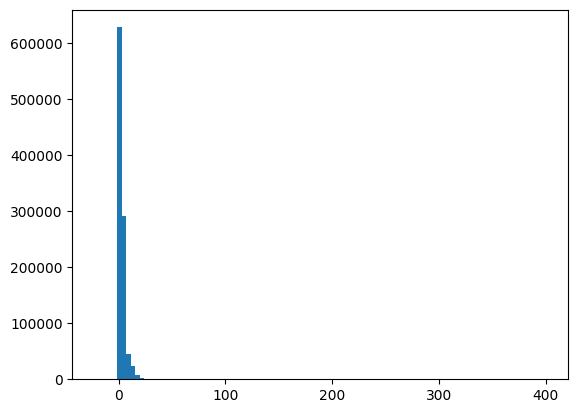

In [7]:
lower_limit, upper_limit = determine_outlier_thresholds_iqr(train_df_yellow[['tip_amount']], 'tip_amount')
print(lower_limit, upper_limit)
plt.hist(train_df_yellow[['tip_amount']], bins=100)
plt.show()

2.963509348789811


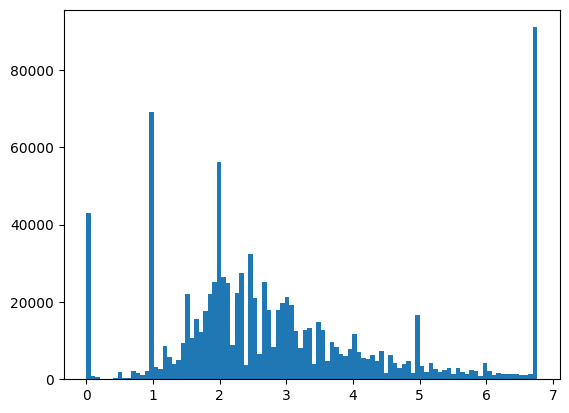

In [8]:
train_df_yellow.loc[(train_df_yellow['tip_amount'] > upper_limit), 'tip_amount'] = upper_limit
train_df_yellow.loc[(train_df_yellow['tip_amount'] <= 0), 'tip_amount'] = 0
plt.hist(train_df_yellow[['tip_amount']], bins=100)
print(train_df_yellow['tip_amount'].mean())
plt.show()

In [9]:
train_df_yellow = train_df_yellow[train_df_yellow['tip_amount'] > 0]
train_df_yellow = train_df_yellow[train_df_yellow['tip_amount'].notnull()]

In [10]:
df_mean_tip_daily_yellow = pd.DataFrame(train_df_yellow['tip_amount'].resample('D').mean())
df_sum_tip_daily_yellow = pd.DataFrame(train_df_yellow['tip_amount'].resample('D').sum())

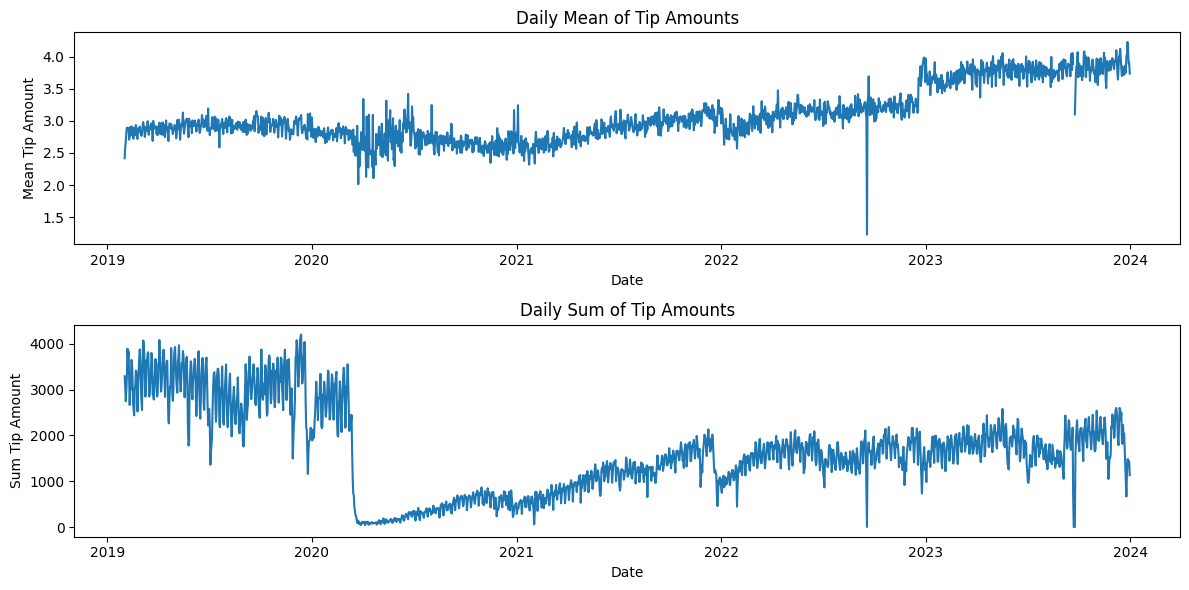

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(df_mean_tip_daily_yellow.index, df_mean_tip_daily_yellow['tip_amount'])
ax[0].set_title('Daily Mean of Tip Amounts')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Tip Amount')

ax[1].plot(df_sum_tip_daily_yellow.index, df_sum_tip_daily_yellow['tip_amount'])
ax[1].set_title('Daily Sum of Tip Amounts')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Sum Tip Amount')

plt.tight_layout()
plt.show()

In [12]:
df_mean_tip_weekly_yellow = pd.DataFrame(train_df_yellow['tip_amount'].resample('W').mean())

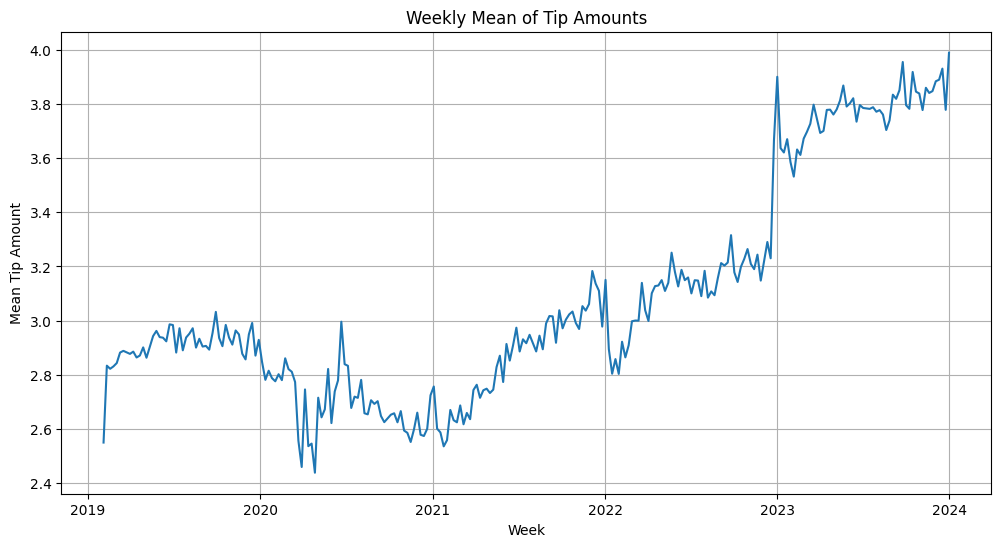

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_mean_tip_weekly_yellow.index, df_mean_tip_weekly_yellow['tip_amount'])
plt.title('Weekly Mean of Tip Amounts')
plt.xlabel('Week')
plt.ylabel('Mean Tip Amount')
plt.grid(True)
plt.show()

#### Fare amount

-6.5 29.5


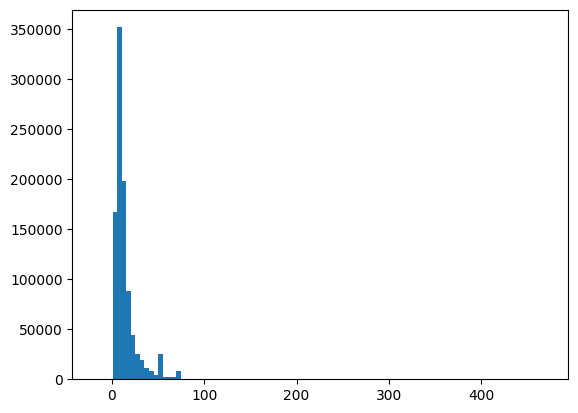

In [14]:
lower_limit, upper_limit = determine_outlier_thresholds_iqr(train_df_yellow[['fare_amount']], 'fare_amount')
print(lower_limit, upper_limit)
plt.hist(train_df_yellow[['fare_amount']], bins=100)
plt.show()

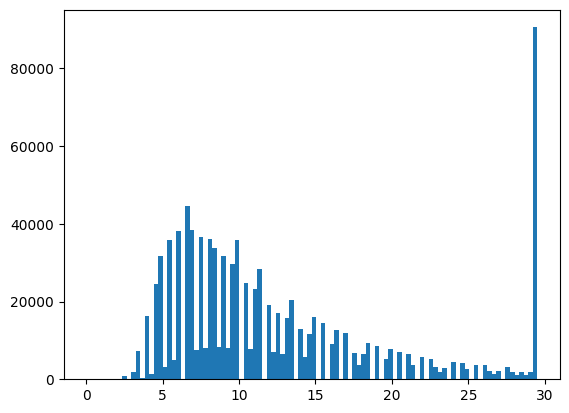

In [15]:
train_df_yellow.loc[(train_df_yellow['fare_amount'] > upper_limit), 'fare_amount'] = upper_limit
train_df_yellow.loc[(train_df_yellow['fare_amount'] <= 0), 'fare_amount'] = 0
plt.hist(train_df_yellow[['fare_amount']], bins=100)
plt.show()

In [16]:
train_df_yellow = train_df_yellow[train_df_yellow['fare_amount'] > 0]
train_df_yellow = train_df_yellow[train_df_yellow['fare_amount'].notnull()]

In [19]:
df_mean_fare_daily_yellow = pd.DataFrame(train_df_yellow['fare_amount'].resample('D').mean())
df_sum_fare_daily_yellow = pd.DataFrame(train_df_yellow['fare_amount'].resample('D').sum())

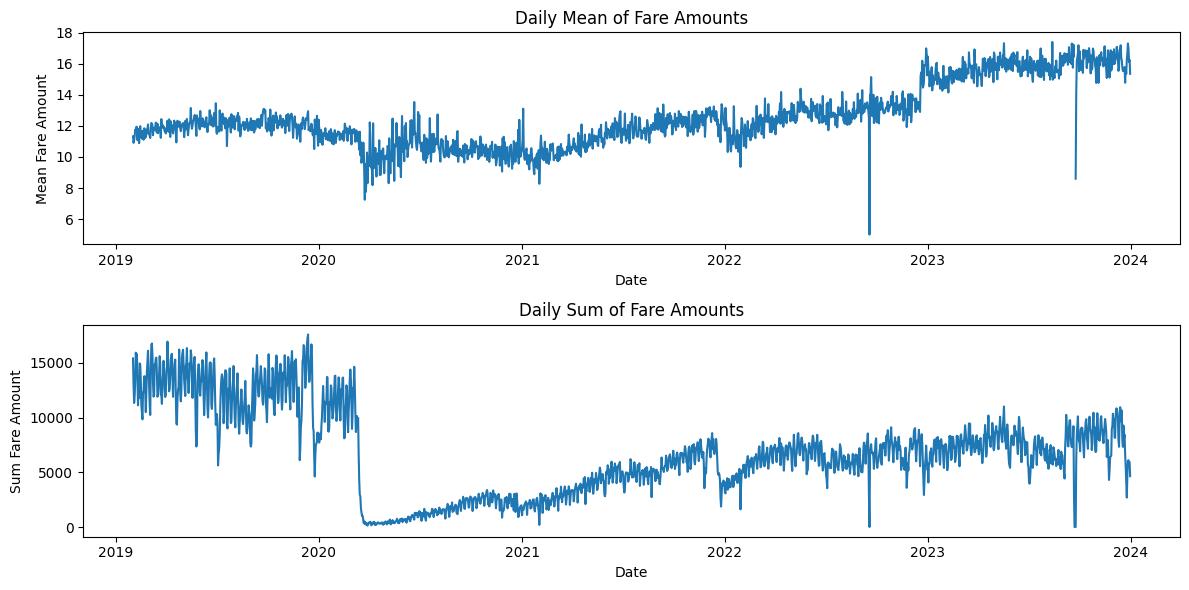

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(df_mean_fare_daily_yellow.index, df_mean_fare_daily_yellow['fare_amount'])
ax[0].set_title('Daily Mean of Fare Amounts')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Fare Amount')

ax[1].plot(df_sum_fare_daily_yellow.index, df_sum_fare_daily_yellow['fare_amount'])
ax[1].set_title('Daily Sum of Fare Amounts')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Sum Fare Amount')

plt.tight_layout()
plt.show()

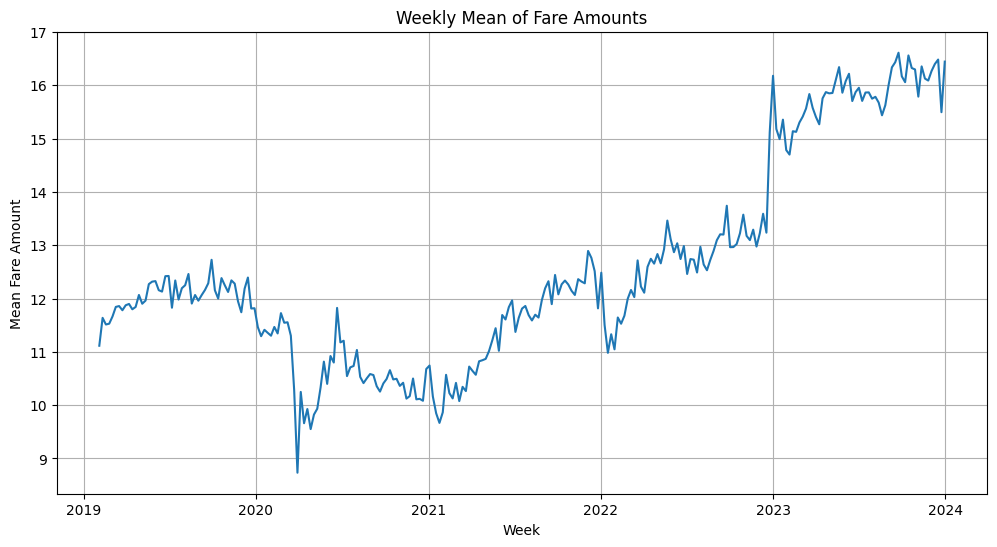

In [21]:
df_mean_fare_weekly_yellow = pd.DataFrame(train_df_yellow['fare_amount'].resample('W').mean())
plt.figure(figsize=(12, 6))
plt.plot(df_mean_fare_weekly_yellow.index, df_mean_fare_weekly_yellow['fare_amount'])
plt.title('Weekly Mean of Fare Amounts')
plt.xlabel('Week')
plt.ylabel('Mean Fare Amount')
plt.grid(True)
plt.show()

### Growth

In [22]:
def show_growth(feature_name, df):
    df_copy = df.copy()
    df_copy[f"{feature_name}_abs_growth"] = df[feature_name].diff()
    df_copy[f'{feature_name}_pct_change'] = df[feature_name].pct_change().mul(100)

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    ax[0].plot(df_copy.index, df_copy[f'{feature_name}_abs_growth'])
    ax[0].set_title(f'{feature_name} Absolute Growth Over Time')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Growth')
    ax[0].grid(True)

    ax[1].plot(df_copy.index, df_copy[f'{feature_name}_pct_change'])
    ax[1].set_title(f'{feature_name} Relative Growth Over Time')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Growth')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2117874/2356111628.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_copy[f'{feature_name}_pct_change'] = df[feature_name].pct_change().mul(100)


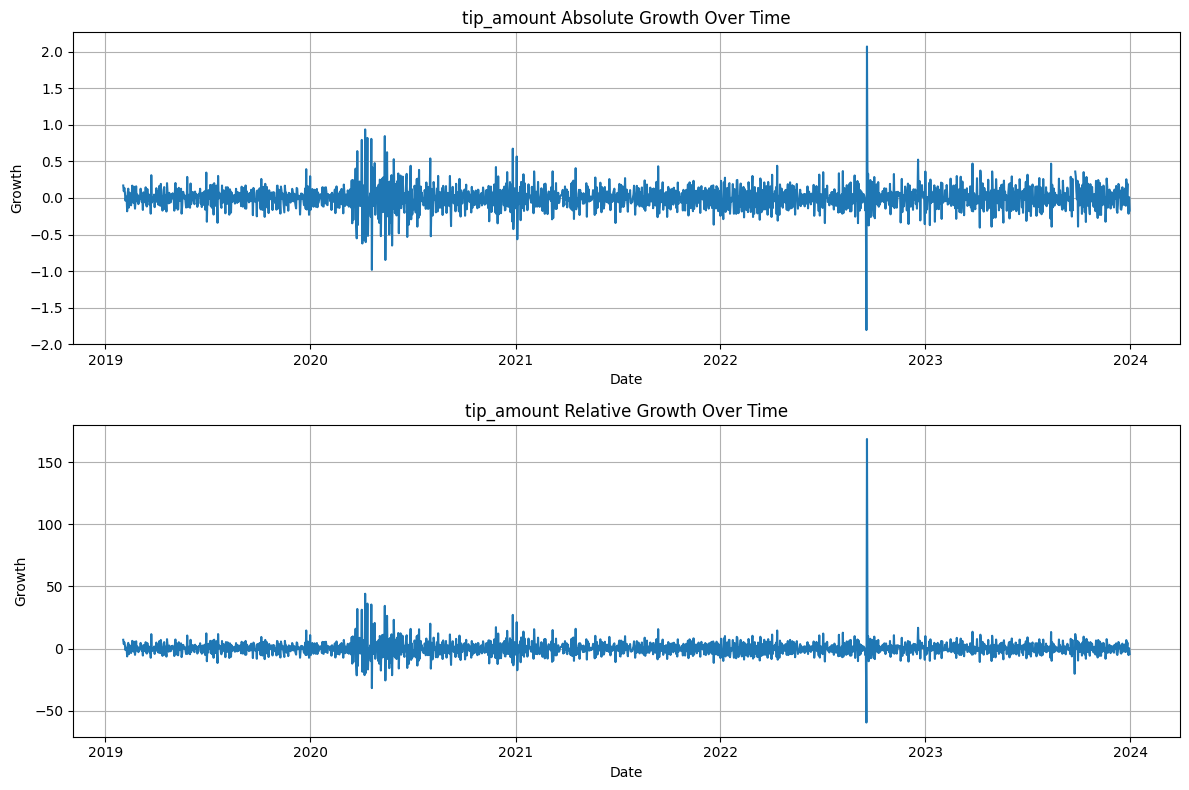

In [23]:
show_growth('tip_amount', df_mean_tip_daily_yellow)

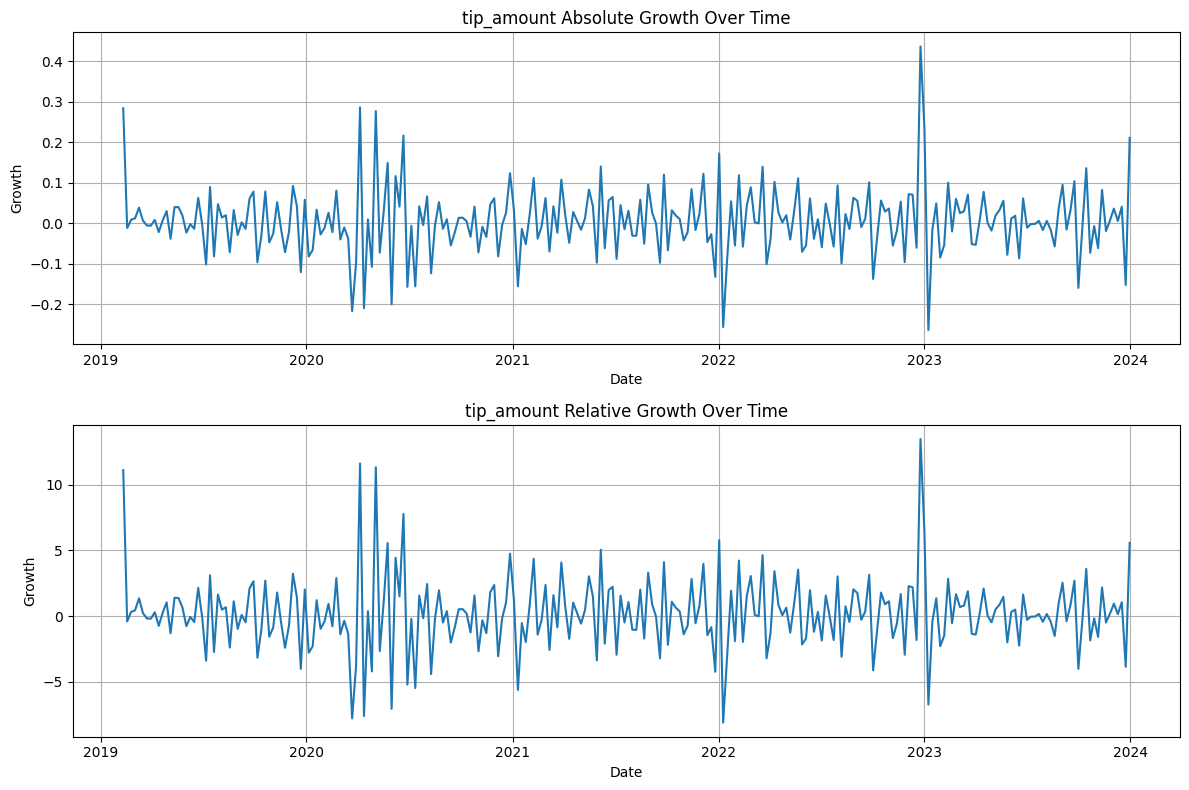

In [24]:
show_growth('tip_amount', df_mean_tip_weekly_yellow)

/tmp/ipykernel_2117874/2356111628.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_copy[f'{feature_name}_pct_change'] = df[feature_name].pct_change().mul(100)


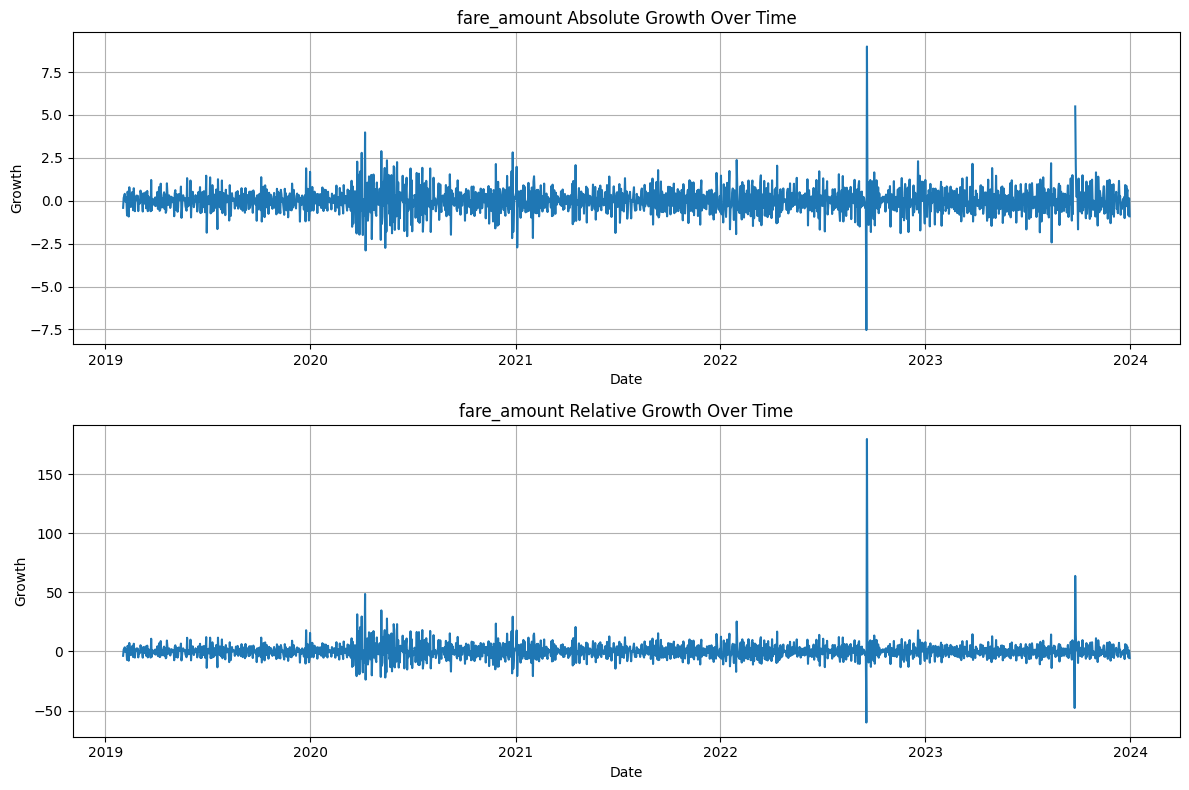

In [25]:
show_growth('fare_amount', df_mean_fare_daily_yellow)

### Rolling windows

In [76]:
def show_windows(feature_name, df, windows_sizes=[7, 14, 30]):
    df_copy = df.copy()
    if (len(windows_sizes) > 1):        
        fig, axs = plt.subplots(len(windows_sizes), 1, figsize=(12, 4 * len(windows_sizes)))
        for i, size in enumerate(windows_sizes):
            df_copy[f"moving_average_{size}"] = df_copy[feature_name].rolling(window=size).mean()

            axs[i].plot(df_copy[feature_name], label=feature_name)
            axs[i].plot(df_copy[f"moving_average_{size}"], label=f"Moving Average {size}")
            axs[i].set_title(f"{feature_name} with Moving Average {size}")
            axs[i].set_ylabel(f"{feature_name}")
            axs[i].grid(True)
            axs[i].legend()
    
    else:
        plt.figure(figsize=(12, 6))
        for i, size in enumerate(windows_sizes):
            df_copy[f"moving_average_{size}"] = df_copy[feature_name].rolling(window=size).mean()
            plt.plot(df_copy[feature_name], label=feature_name)
            plt.plot(df_copy[f"moving_average_{size}"], label=f"Moving Average {size}")
            plt.title(f"{feature_name} with Moving Average {size}")
            plt.ylabel(f"{feature_name}")
            plt.grid(True)
            plt.legend()
            
    plt.tight_layout()
    plt.show()

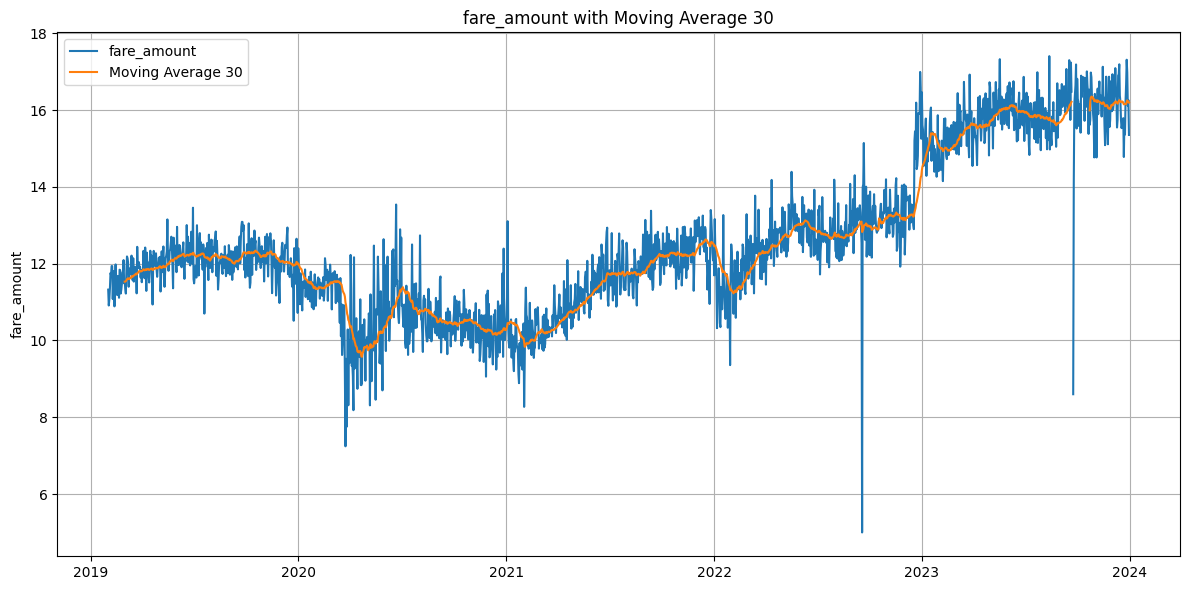

In [81]:
show_windows("fare_amount", df_mean_fare_daily_yellow, [30])

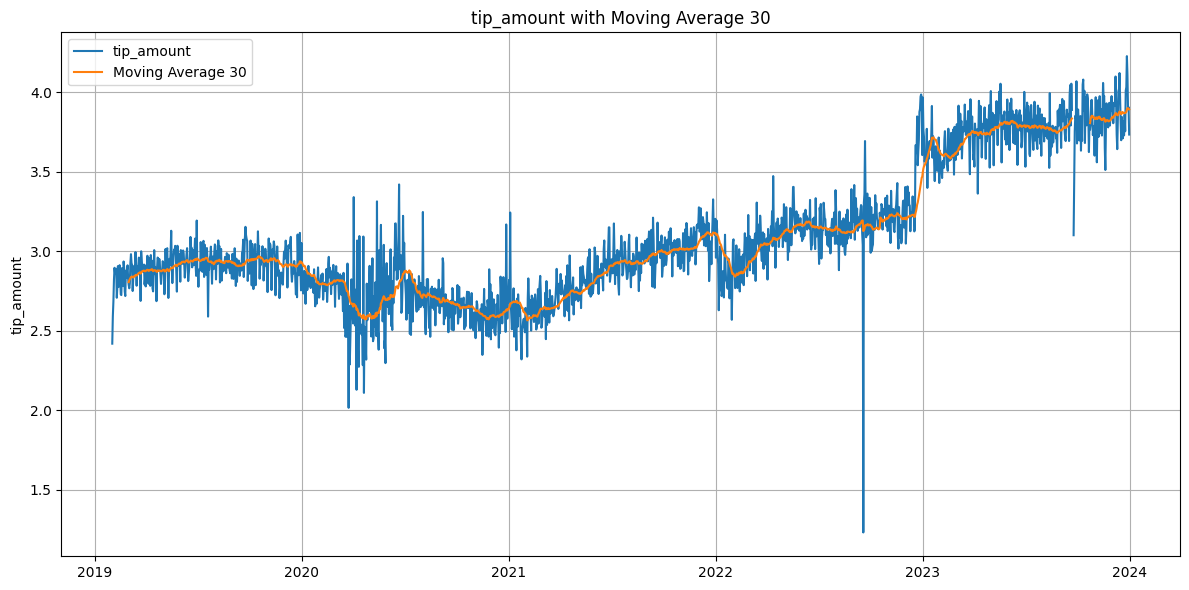

In [28]:
show_windows("tip_amount", df_mean_tip_daily_yellow, [30])

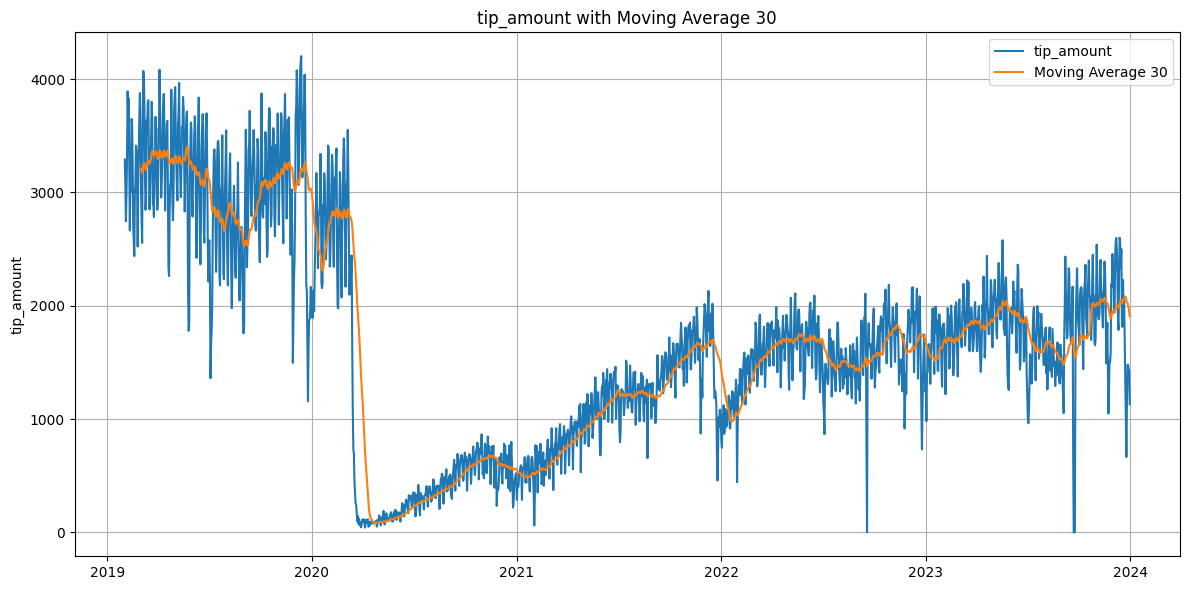

In [29]:
show_windows("tip_amount", df_sum_tip_daily_yellow, [30])

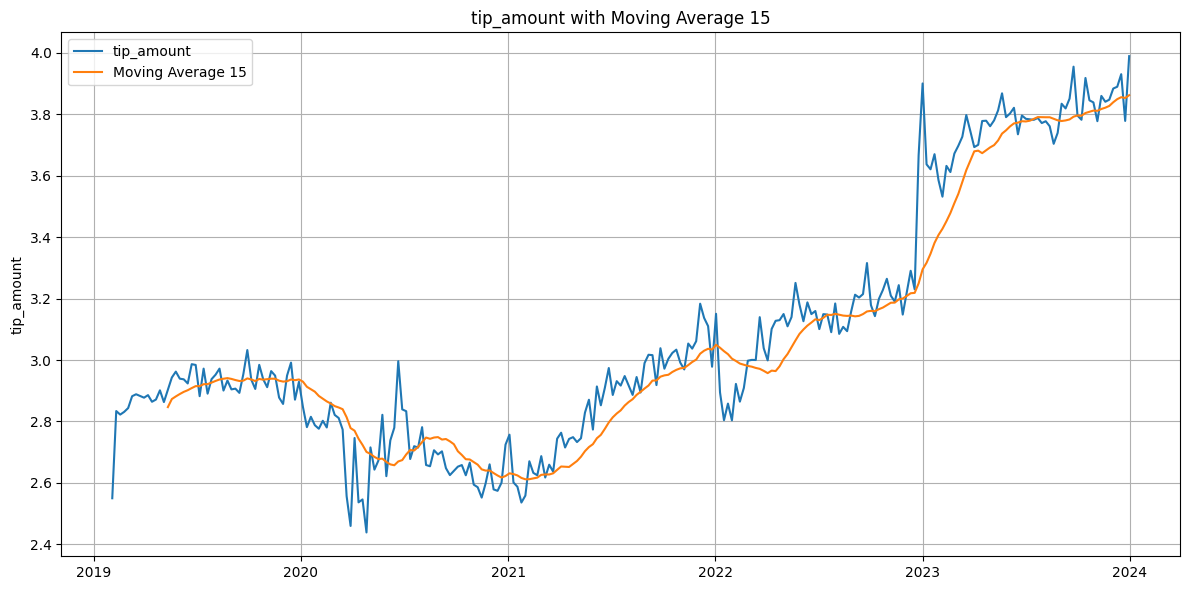

In [93]:
show_windows("tip_amount", df_mean_tip_weekly_yellow, [15])

In [97]:
from statsmodels.tsa.arima.model import ARIMA
ma_model = ARIMA(endog=df_mean_tip_weekly_yellow['tip_amount'], order=(0,0,55))
results = ma_model.fit()
print(results.summary())

/home/fip/zajecia/ed/lab/ed-lab/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fip/zajecia/ed/lab/ed-lab/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             tip_amount   No. Observations:                  257
Model:                ARIMA(0, 0, 55)   Log Likelihood                 310.459
Date:                Mon, 10 Jun 2024   AIC                           -506.918
Time:                        20:32:38   BIC                           -304.621
Sample:                    02-03-2019   HQIC                          -425.564
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1045      0.164     18.980      0.000       2.784       3.425
ma.L1          0.6805      0.141      4.814      0.000       0.403       0.957
ma.L2          0.7099      0.150      4.748      0.0

In [98]:
df_mean_tip_weekly_yellow.tail(10)

tip_amount
tpep_pickup_datetime            
2023-10-29              3.838166
2023-11-05              3.777000
2023-11-12              3.859262
2023-11-19              3.840237
2023-11-26              3.847020
2023-12-03              3.883305
2023-12-10              3.889045
2023-12-17              3.930022
2023-12-24              3.777903
2023-12-31              3.988629

In [101]:
start_date = '2024-01-01'
end_date = '2024-03-01'
df_mean_tip_weekly_yellow['prediction'] = results.predict(start=start_date, end=end_date)

[]

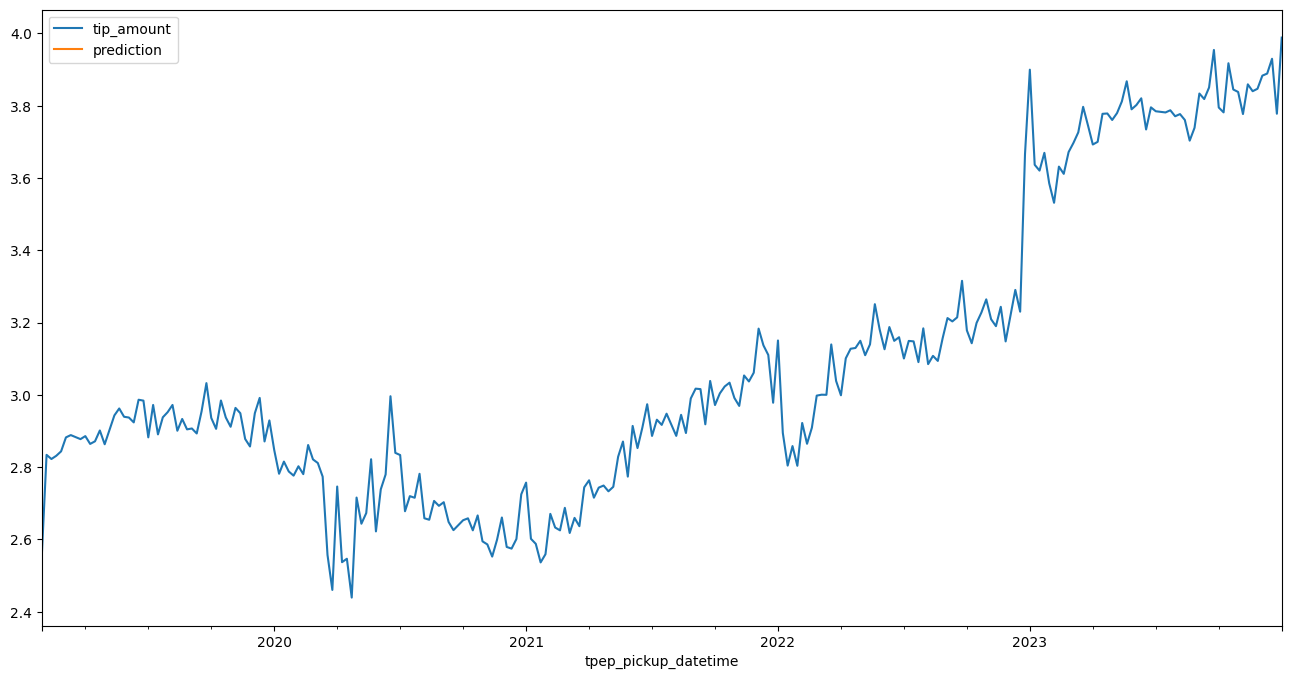

In [102]:
forecast_steps = 60
forecast_index = pd.date_range(start=df_mean_tip_weekly_yellow['tip_amount'].index[-1], periods=forecast_steps+1, freq='W')[1:]  # Generate datetime index for forecast
forecast = results.forecast(steps=forecast_steps)

df_mean_tip_weekly_yellow[['tip_amount', 'prediction']].plot()
plt.plot(forecast_index, forecast, color='red', label='Forecast') 

### Seasonality

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

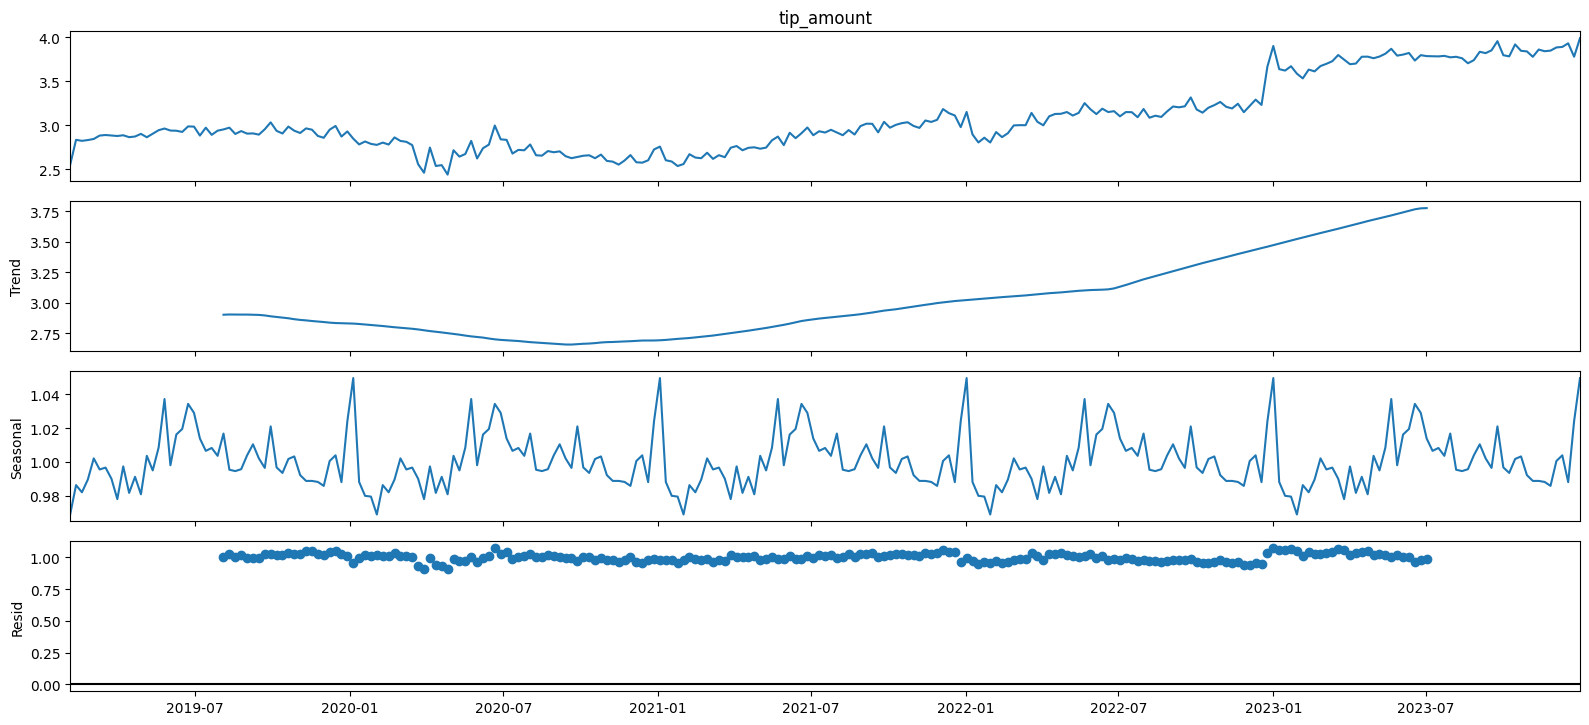

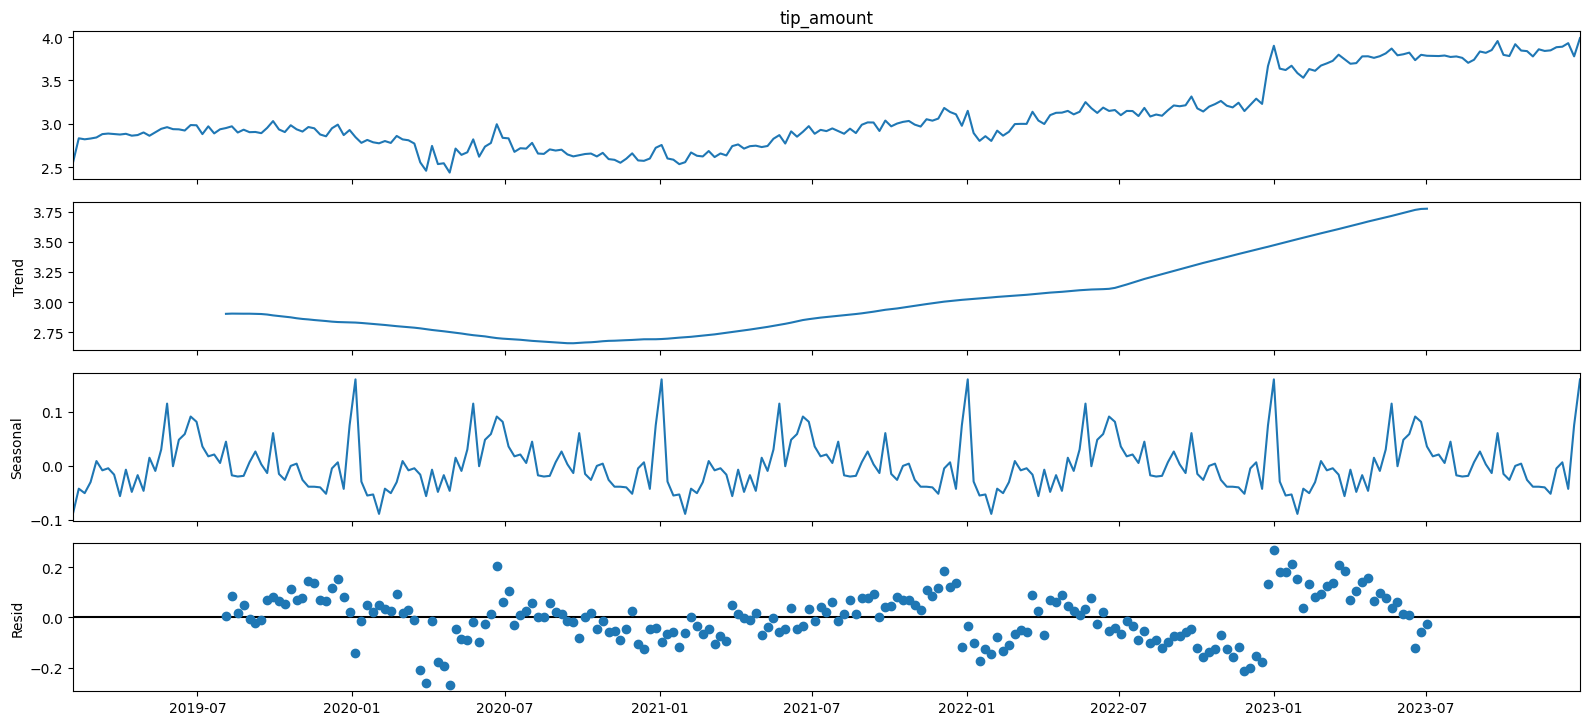

In [32]:
multi_sd_tip_yellow = seasonal_decompose(df_mean_tip_weekly_yellow['tip_amount'], model='multiplicative', period=52)
add_sd_tip_yellow = seasonal_decompose(df_mean_tip_weekly_yellow['tip_amount'], model='additive', period=52)

plt.rcParams.update({'figure.figsize': (16, 8)})
multi_sd_tip_yellow.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

add_sd_tip_yellow.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

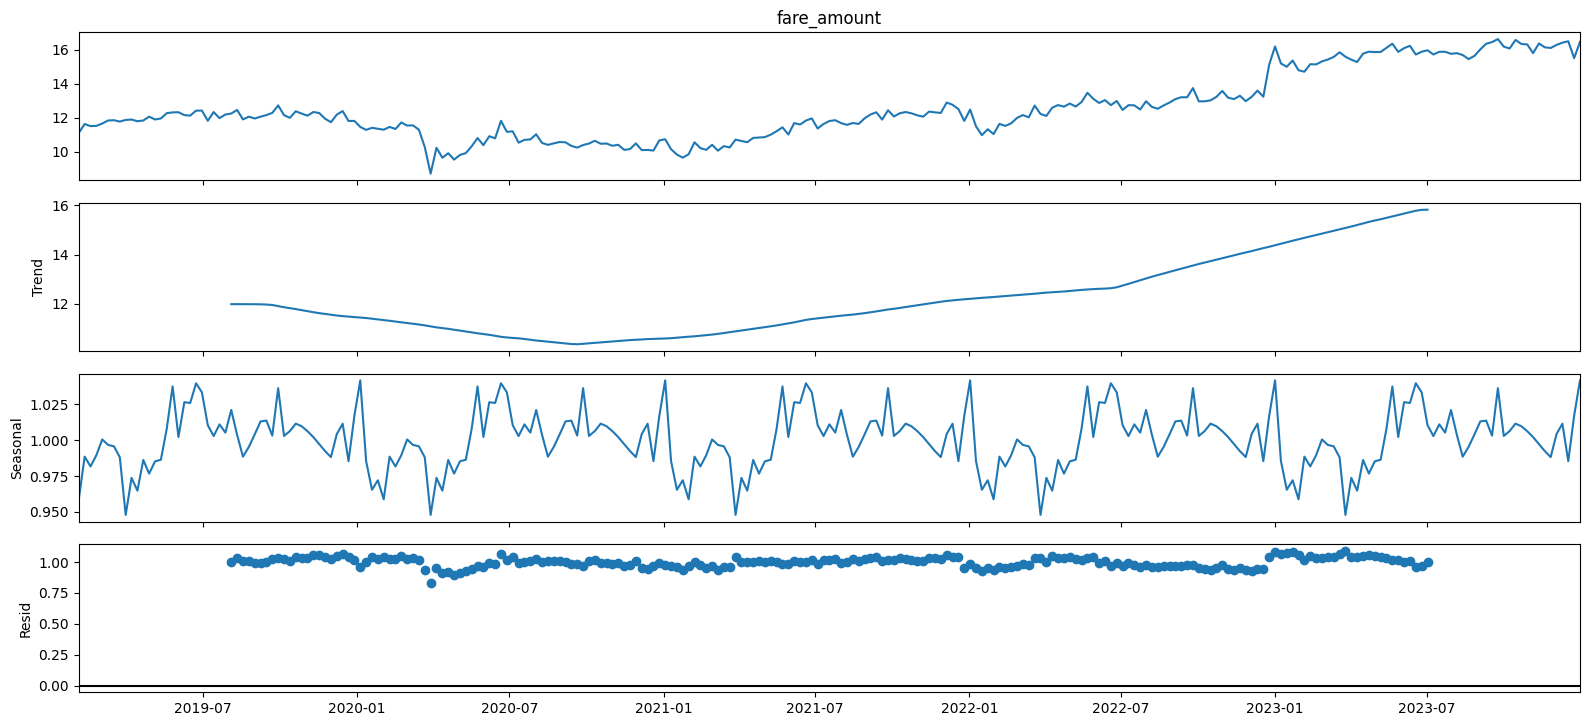

In [33]:
multi_sd_fare_yellow = seasonal_decompose(df_mean_fare_weekly_yellow['fare_amount'], model='multiplicative', period=52)

plt.rcParams.update({'figure.figsize': (16, 8)})
multi_sd_fare_yellow.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#### Deseasonalized

In [34]:
deseas_fare_yellow = df_mean_fare_weekly_yellow['fare_amount'].values - multi_sd_fare_yellow.seasonal
deseas_tip_yellow = df_mean_tip_weekly_yellow['tip_amount'].values - multi_sd_tip_yellow.seasonal

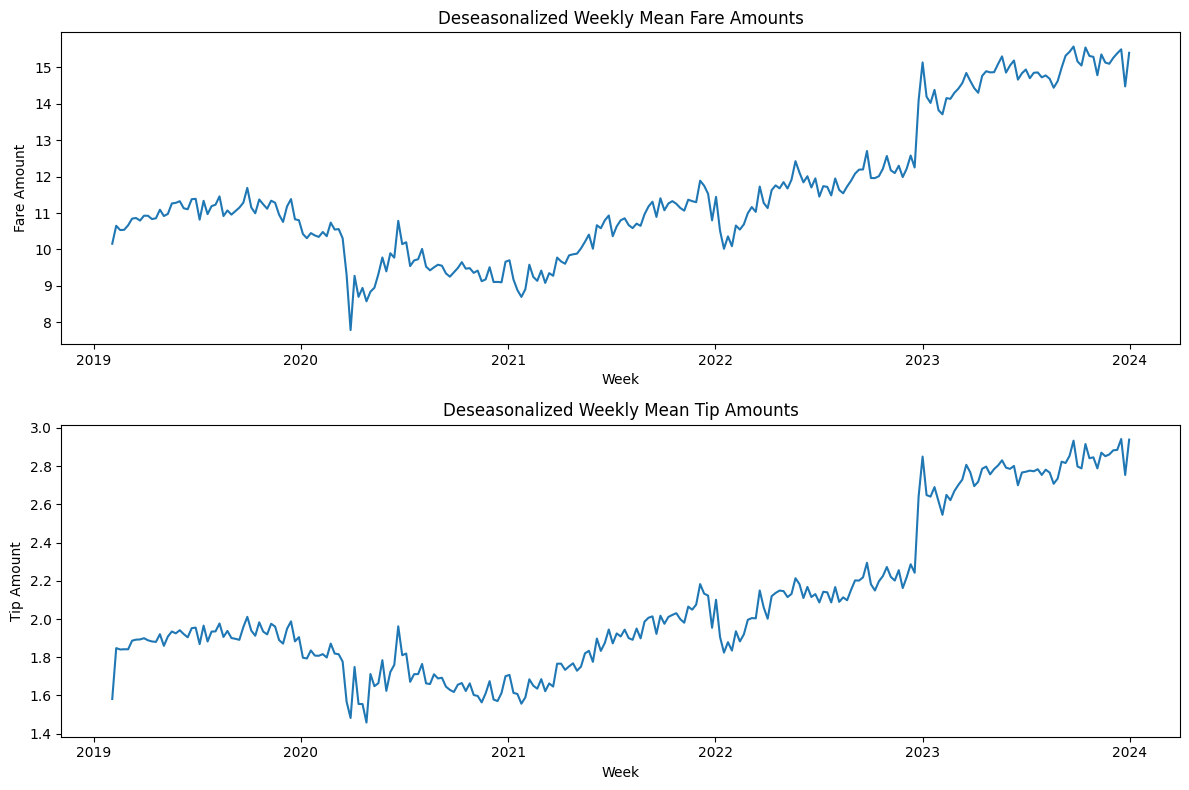

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(deseas_fare_yellow)
ax[0].set_title('Deseasonalized Weekly Mean Fare Amounts')
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Fare Amount')

ax[1].plot(deseas_tip_yellow)
ax[1].set_title('Deseasonalized Weekly Mean Tip Amounts')
ax[1].set_xlabel('Week')
ax[1].set_ylabel('Tip Amount')

plt.tight_layout()
plt.show()

trendy liniowe, dopasowanie trendow, wskaznik sezonowosci

In [36]:
plt.rcParams.update({'figure.figsize': (6, 6)})

## Green taxi

In [37]:
train_df_green = pd.read_parquet(base_path + 'green_train_1M.parquet')
train_df_green = train_df_green.sort_values(by="lpep_pickup_datetime")
train_df_green.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime  \
790518         2  2008-12-31 19:16:53   2008-12-31 19:34:36   
702613         2  2008-12-31 23:05:26   2009-01-01 10:58:56   
311404         2  2009-01-01 00:02:25   2009-01-01 12:42:14   
824924         2  2009-01-01 00:05:15   2009-01-01 00:05:21   
914009         2  2009-01-01 00:05:35   2009-01-01 13:03:53   

       store_and_fwd_flag  RatecodeID  PULocationID  DOLocationID  \
790518                  N         1.0            74           264   
702613                  N         1.0           193           193   
311404                  N         1.0            92            71   
824924                  N         1.0           193           193   
914009                  N         1.0           193           193   

        passenger_count  trip_distance  fare_amount  ...  dew_point_2m (°C)  \
790518              1.0           3.29         12.5  ...              -24.6   
702613              1.0           0.00          0.0  ...              -24.6   
311404              1.0          24.07         80.5  ...              -24.6   
824924              1.0           0.00          0.0  ...              -24.6   
914009              1.0           0.00          0.0  ...              -24.6   

        apparent_temperature (°C)  precipitation (mm)  rain (mm)  \
790518                      -16.1                 0.0        0.0   
702613                      -16.1                 0.0        0.0   
311404                      -16.1                 0.0        0.0   
824924                      -16.1                 0.0        0.0   
914009                      -16.1                 0.0        0.0   

        snowfall (cm)  snow_depth (m)  surface_pressure (hPa)  \
790518            0.0            0.01                  1023.6   
702613            0.0            0.01                  1023.6   
311404            0.0            0.01                  1023.6   
824924            0.0            0.01                  1023.6   
914009            0.0            0.01                  1023.6   

        cloud_cover (%)  wind_speed_10m (km/h)  is_day ()  
790518                0                   12.1          0  
702613                0                   12.1          0  
311404                0                   12.1          0  
824924                0                   12.1          0  
914009                0                   12.1          0  

[5 rows x 33 columns]

In [38]:
train_df_green = train_df_green[train_df_green['lpep_pickup_datetime'] >= '2019-02-01']
train_df_green.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
23569         2  2019-02-01 00:00:13   2019-02-01 00:07:38                  N   
11501         2  2019-02-01 00:00:25   2019-02-01 00:04:23                  N   
15427         2  2019-02-01 00:04:00   2019-02-01 00:22:22                  N   
42740         2  2019-02-01 00:04:07   2019-02-01 00:06:49                  N   
26927         1  2019-02-01 00:05:24   2019-02-01 00:14:00                  N   

       RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
23569         1.0            25            49              1.0           1.60   
11501         1.0            75           236              1.0           0.69   
15427         1.0           166           119              1.0           4.46   
42740         1.0           181           181              1.0           0.54   
26927         5.0            97           181              1.0           1.20   

       fare_amount  ...  dew_point_2m (°C)  apparent_temperature (°C)  \
23569          7.5  ...              -24.6                      -16.1   
11501          5.0  ...              -24.6                      -16.1   
15427         16.5  ...              -24.6                      -16.1   
42740          4.0  ...              -24.6                      -16.1   
26927         10.0  ...              -24.6                      -16.1   

       precipitation (mm)  rain (mm)  snowfall (cm)  snow_depth (m)  \
23569                 0.0        0.0            0.0            0.01   
11501                 0.0        0.0            0.0            0.01   
15427                 0.0        0.0            0.0            0.01   
42740                 0.0        0.0            0.0            0.01   
26927                 0.0        0.0            0.0            0.01   

       surface_pressure (hPa)  cloud_cover (%)  wind_speed_10m (km/h)  \
23569                  1023.6                0                   12.1   
11501                  1023.6                0                   12.1   
15427                  1023.6                0                   12.1   
42740                  1023.6                0                   12.1   
26927                  1023.6                0                   12.1   

       is_day ()  
23569          0  
11501          0  
15427          0  
42740          0  
26927          0  

[5 rows x 33 columns]

In [40]:
train_df_green.set_index('lpep_pickup_datetime', inplace=True)

### Outliers & Resampling

#### Tip

-4.5 7.5


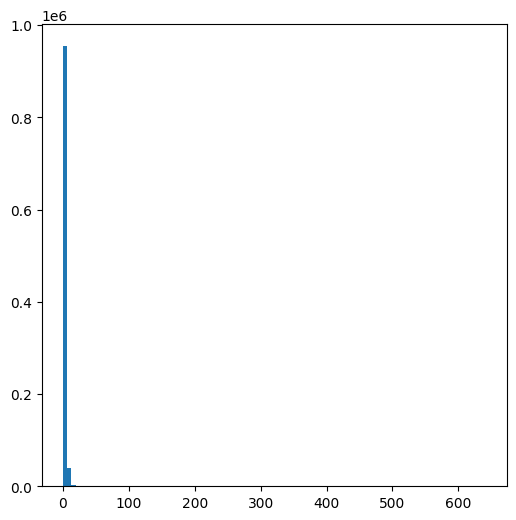

In [41]:
lower_limit, upper_limit = determine_outlier_thresholds_iqr(train_df_green[['tip_amount']], 'tip_amount')
print(lower_limit, upper_limit)
plt.hist(train_df_green[['tip_amount']], bins=100)
plt.show()

2.102254166929178


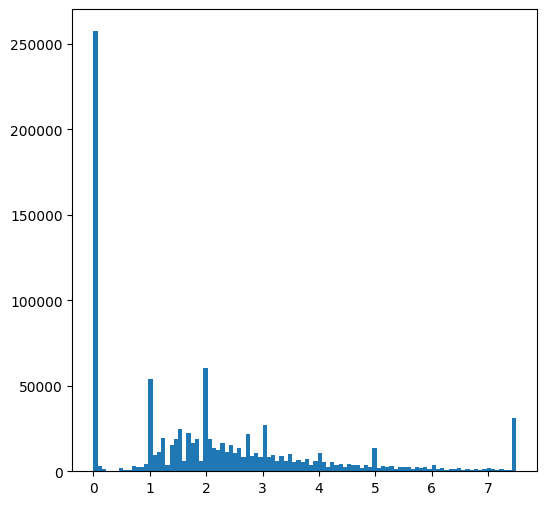

In [42]:
train_df_green.loc[(train_df_green['tip_amount'] > upper_limit), 'tip_amount'] = upper_limit
train_df_green.loc[(train_df_green['tip_amount'] <= 0), 'tip_amount'] = 0
plt.hist(train_df_green[['tip_amount']], bins=100)
print(train_df_green['tip_amount'].mean())
plt.show()

In [43]:
train_df_green = train_df_green[train_df_green['tip_amount'] > 0]
train_df_green = train_df_green[train_df_green['tip_amount'].notnull()]

In [44]:
df_mean_tip_daily_green = pd.DataFrame(train_df_green['tip_amount'].resample('D').mean())
df_sum_tip_daily_green = pd.DataFrame(train_df_green['tip_amount'].resample('D').sum())

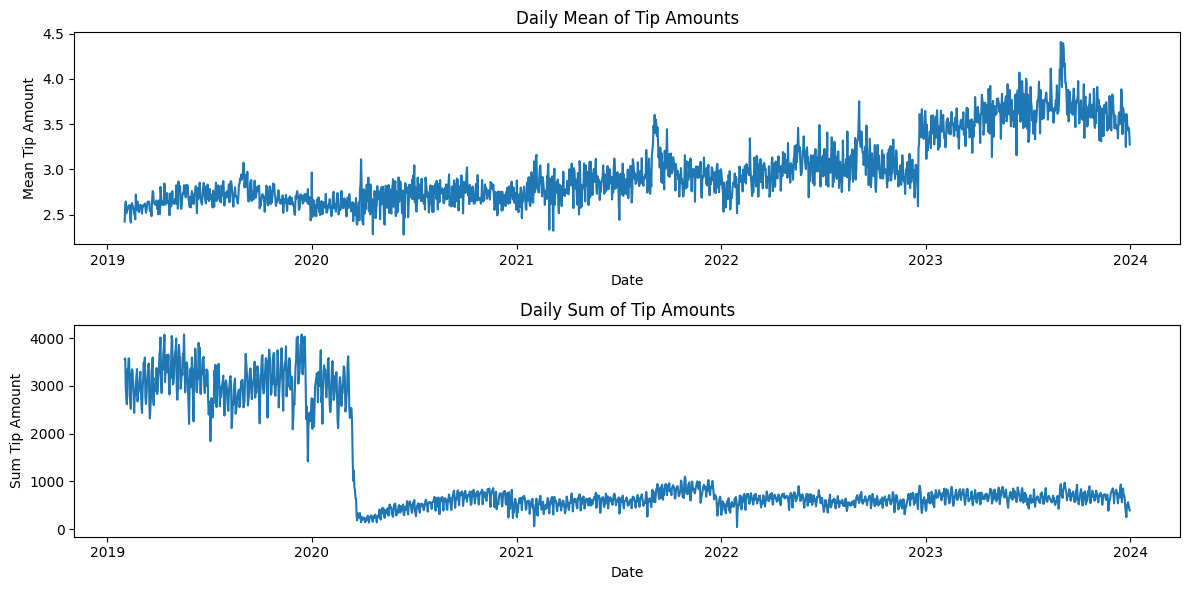

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(df_mean_tip_daily_green.index, df_mean_tip_daily_green['tip_amount'])
ax[0].set_title('Daily Mean of Tip Amounts')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Tip Amount')

ax[1].plot(df_sum_tip_daily_green.index, df_sum_tip_daily_green['tip_amount'])
ax[1].set_title('Daily Sum of Tip Amounts')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Sum Tip Amount')

plt.tight_layout()
plt.show()

In [46]:
df_mean_tip_weekly_green = pd.DataFrame(train_df_green['tip_amount'].resample('W').mean())

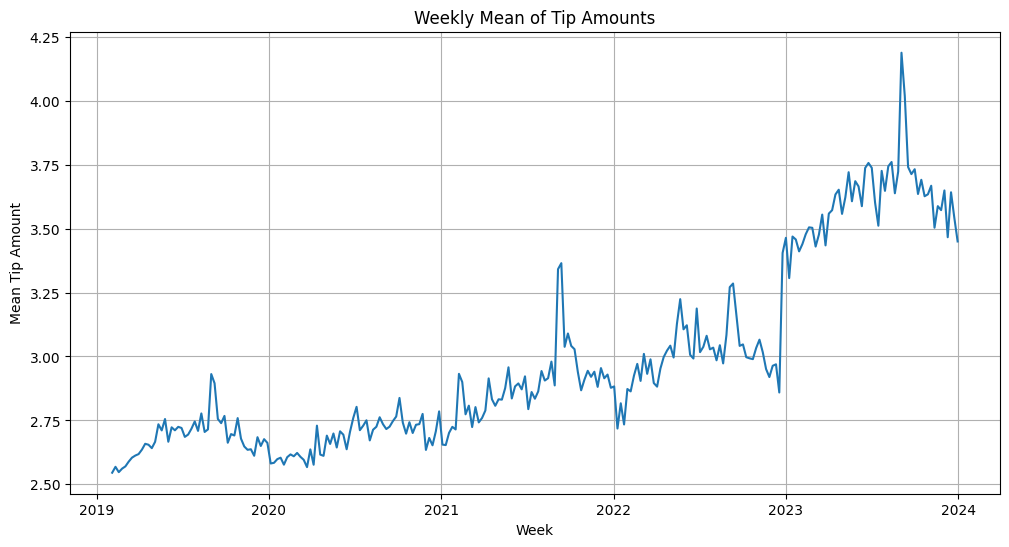

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(df_mean_tip_weekly_green.index, df_mean_tip_weekly_green['tip_amount'])
plt.title('Weekly Mean of Tip Amounts')
plt.xlabel('Week')
plt.ylabel('Mean Tip Amount')
plt.grid(True)
plt.show()

### Growth

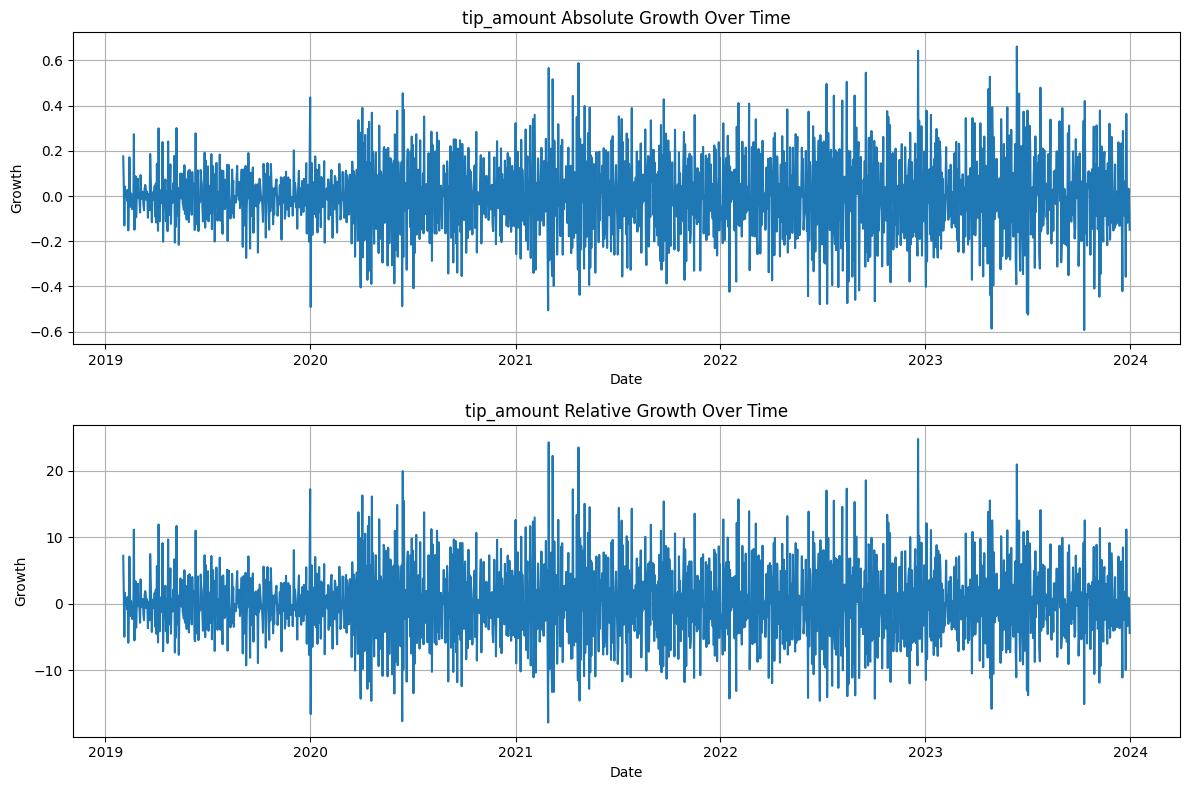

In [48]:
show_growth('tip_amount', df_mean_tip_daily_green)

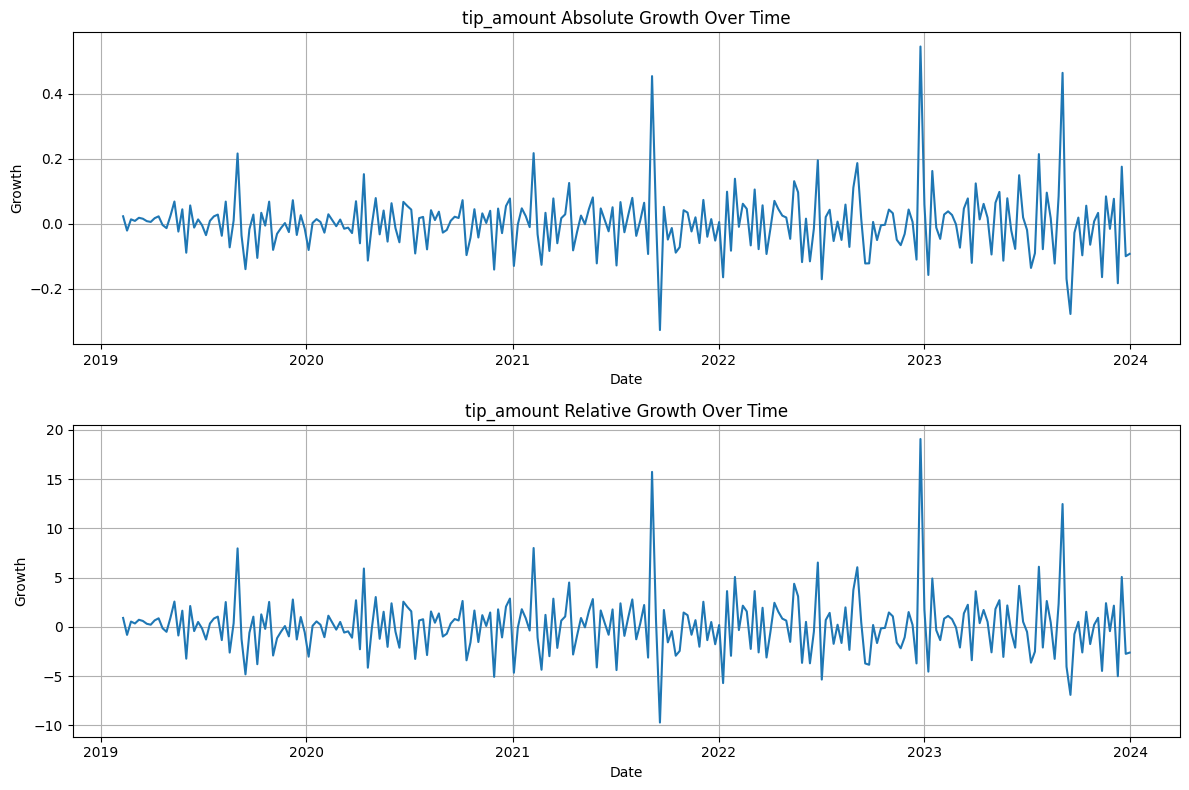

In [49]:
show_growth('tip_amount', df_mean_tip_weekly_green)

### Rolling windows

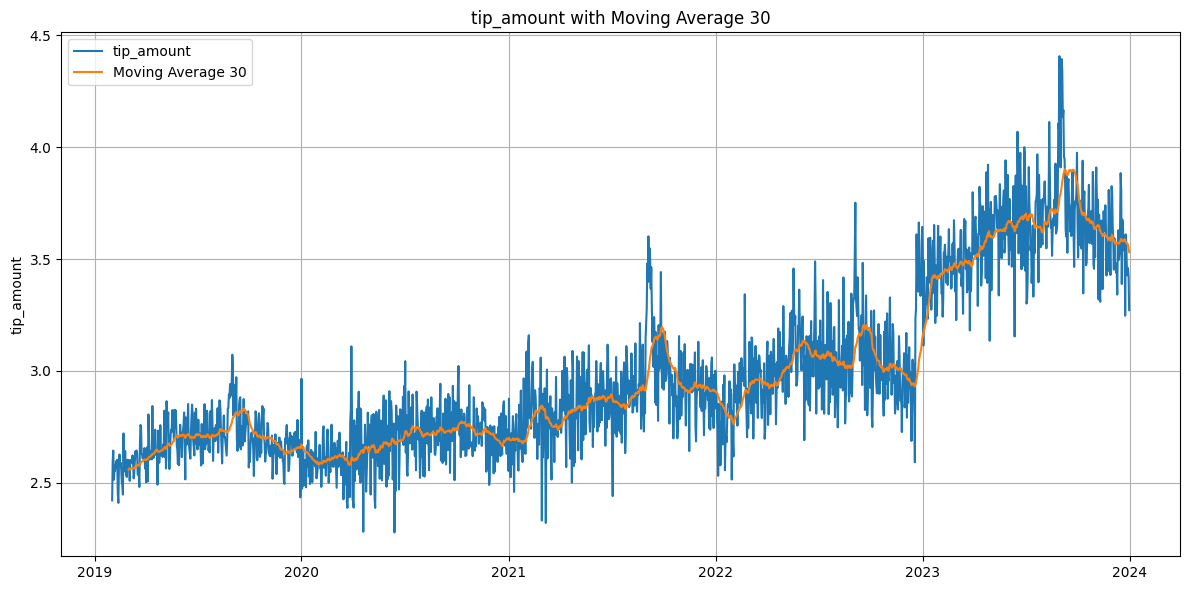

In [50]:
show_windows("tip_amount", df_mean_tip_daily_green, [30])

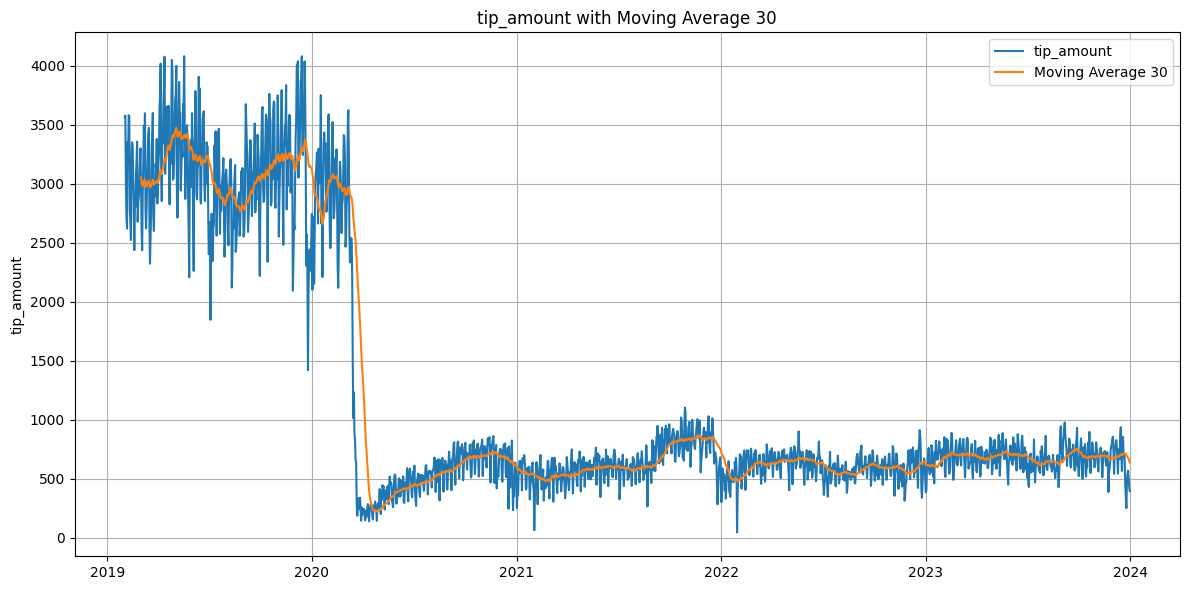

In [51]:
show_windows("tip_amount", df_sum_tip_daily_green, [30])

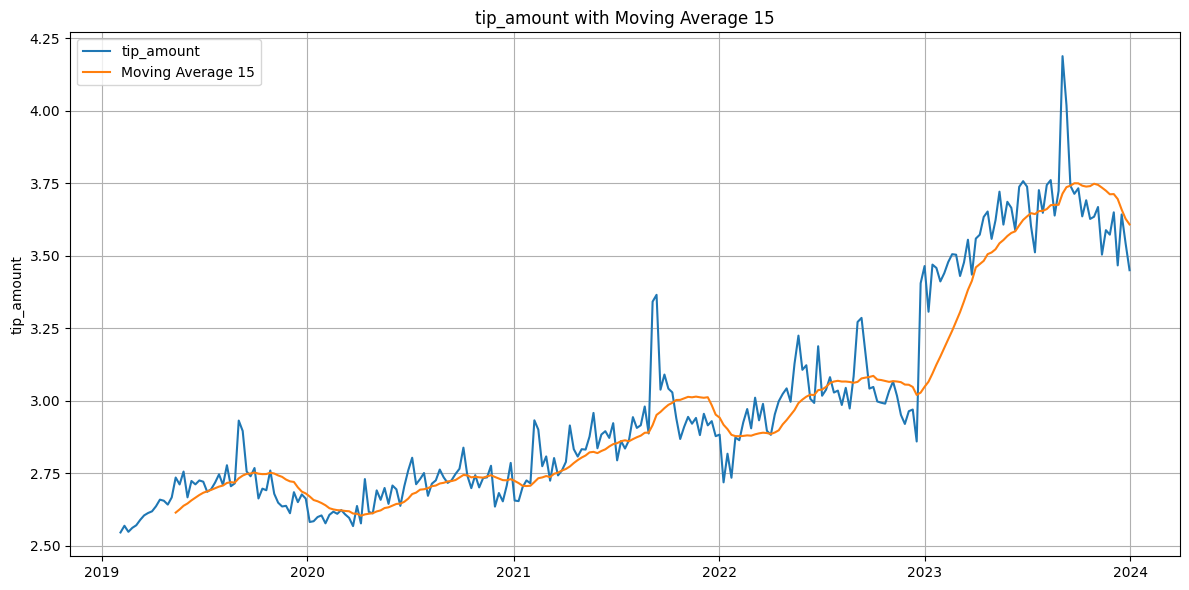

In [52]:
show_windows("tip_amount", df_mean_tip_weekly_green, [15])

### Seasonality

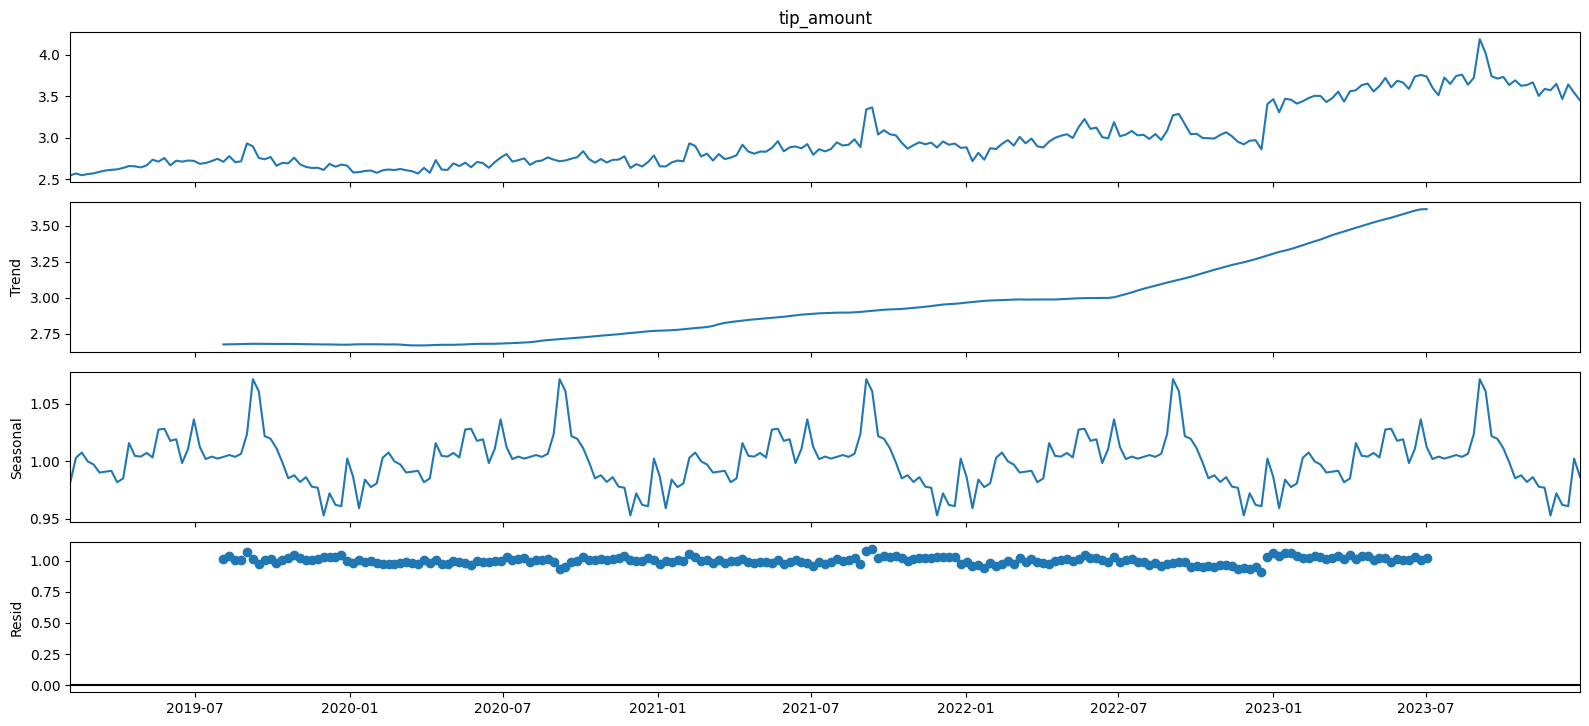

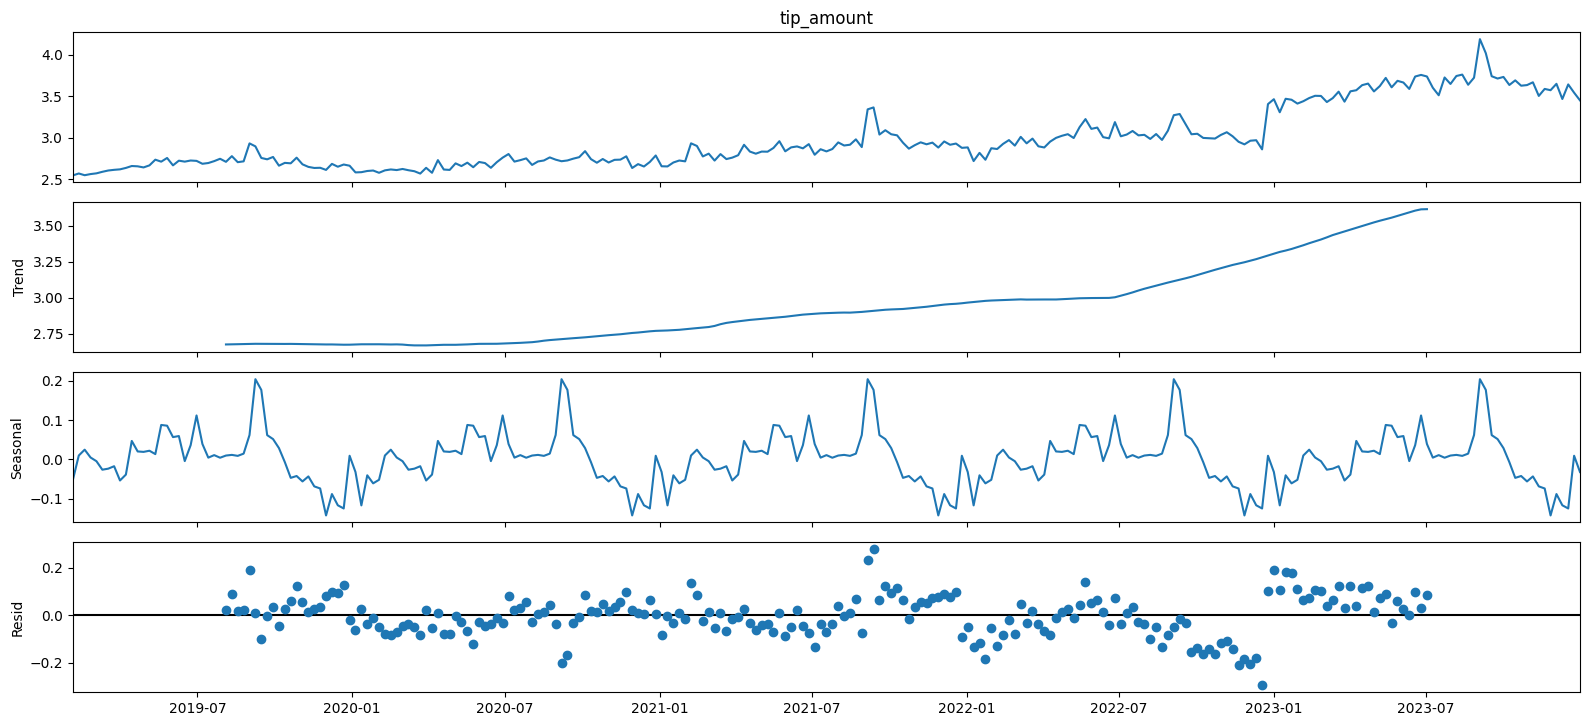

In [53]:
multi_sd_tip_green = seasonal_decompose(df_mean_tip_weekly_green['tip_amount'], model='multiplicative', period=52)
add_sd_tip_green = seasonal_decompose(df_mean_tip_weekly_green['tip_amount'], model='additive', period=52)

plt.rcParams.update({'figure.figsize': (16, 8)})
multi_sd_tip_green.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

add_sd_tip_green.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#### Deseasonalized

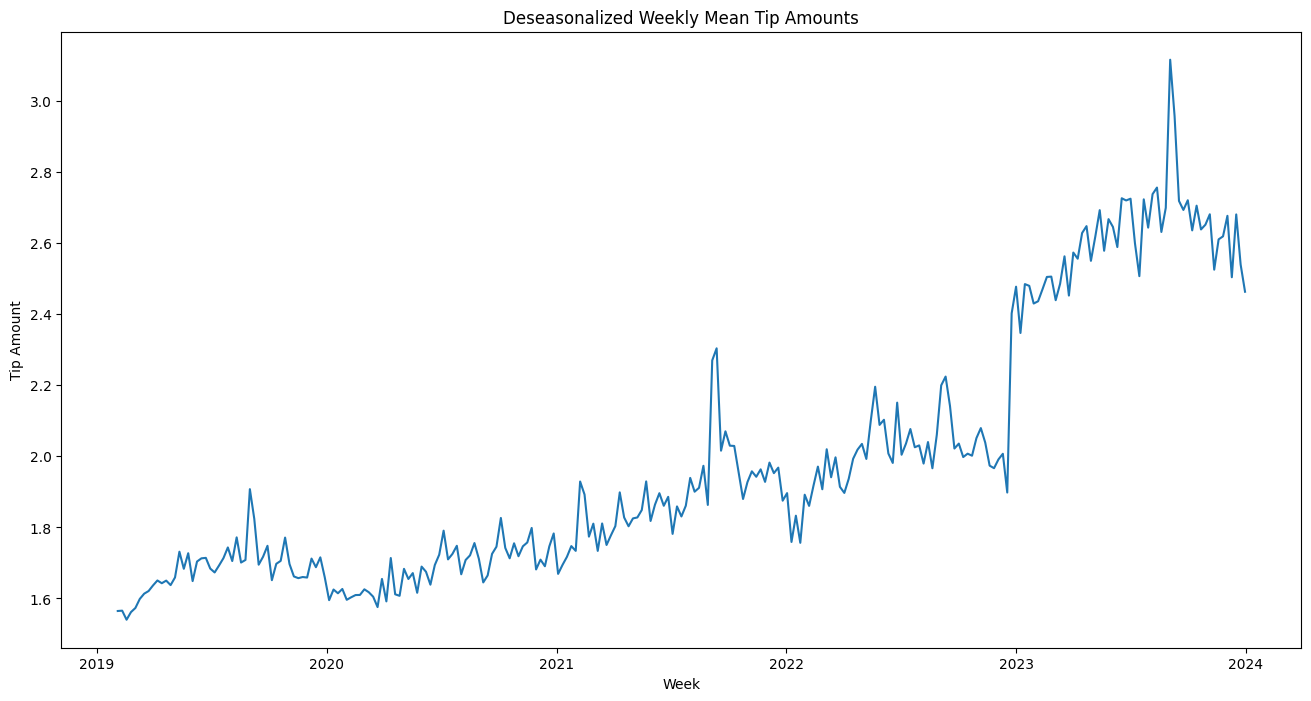

In [54]:
deseas_tip_green = df_mean_tip_weekly_green['tip_amount'].values - multi_sd_tip_green.seasonal
plt.plot(deseas_tip_green)
plt.title('Deseasonalized Weekly Mean Tip Amounts')
plt.xlabel('Week')
plt.ylabel('Tip Amount')
plt.show()


## FHV

In [55]:
train_df_fhv = pd.read_parquet(base_path + 'fhv_train_1M.parquet')
train_df_fhv = train_df_fhv.sort_values(by="pickup_datetime")
train_df_fhv.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
13323            HV0002               B02914               B02914   
19544            HV0003               B02764               B02764   
6975             HV0003               B02877               B02877   
1403             HV0003               B02875               B02875   
4739             HV0003               B02875               B02875   

         request_datetime   on_scene_datetime     pickup_datetime  \
13323 2019-01-31 23:55:38                 NaT 2019-02-01 00:01:38   
19544 2019-02-01 00:02:56 2019-02-01 00:03:02 2019-02-01 00:05:01   
6975  2019-02-01 00:00:15 2019-02-01 00:05:14 2019-02-01 00:06:31   
1403  2019-01-31 23:41:18 2019-02-01 00:07:20 2019-02-01 00:07:26   
4739  2019-02-01 00:05:08 2019-02-01 00:05:22 2019-02-01 00:07:36   

         dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  \
13323 2019-02-01 00:12:17           234           224        1.72  ...   
19544 2019-02-01 00:12:35           152            42        1.56  ...   
6975  2019-02-01 00:26:36           138            40       12.60  ...   
1403  2019-02-01 00:38:09           234           256        4.99  ...   
4739  2019-02-01 00:11:52           159           168        0.83  ...   

       dew_point_2m (°C)  apparent_temperature (°C)  precipitation (mm)  \
13323              -24.6                      -16.1                 0.0   
19544              -24.6                      -16.1                 0.0   
6975               -24.6                      -16.1                 0.0   
1403               -24.6                      -16.1                 0.0   
4739               -24.6                      -16.1                 0.0   

       rain (mm)  snowfall (cm)  snow_depth (m)  surface_pressure (hPa)  \
13323        0.0            0.0            0.01                  1023.6   
19544        0.0            0.0            0.01                  1023.6   
6975         0.0            0.0            0.01                  1023.6   
1403         0.0            0.0            0.01                  1023.6   
4739         0.0            0.0            0.01                  1023.6   

       cloud_cover (%)  wind_speed_10m (km/h) is_day ()  
13323                0                   12.1         0  
19544                0                   12.1         0  
6975                 0                   12.1         0  
1403                 0                   12.1         0  
4739                 0                   12.1         0  

[5 rows x 37 columns]

In [56]:
train_df_fhv.set_index('pickup_datetime', inplace=True)

### Outliers & Resampling

#### Tip

0.0 0.0


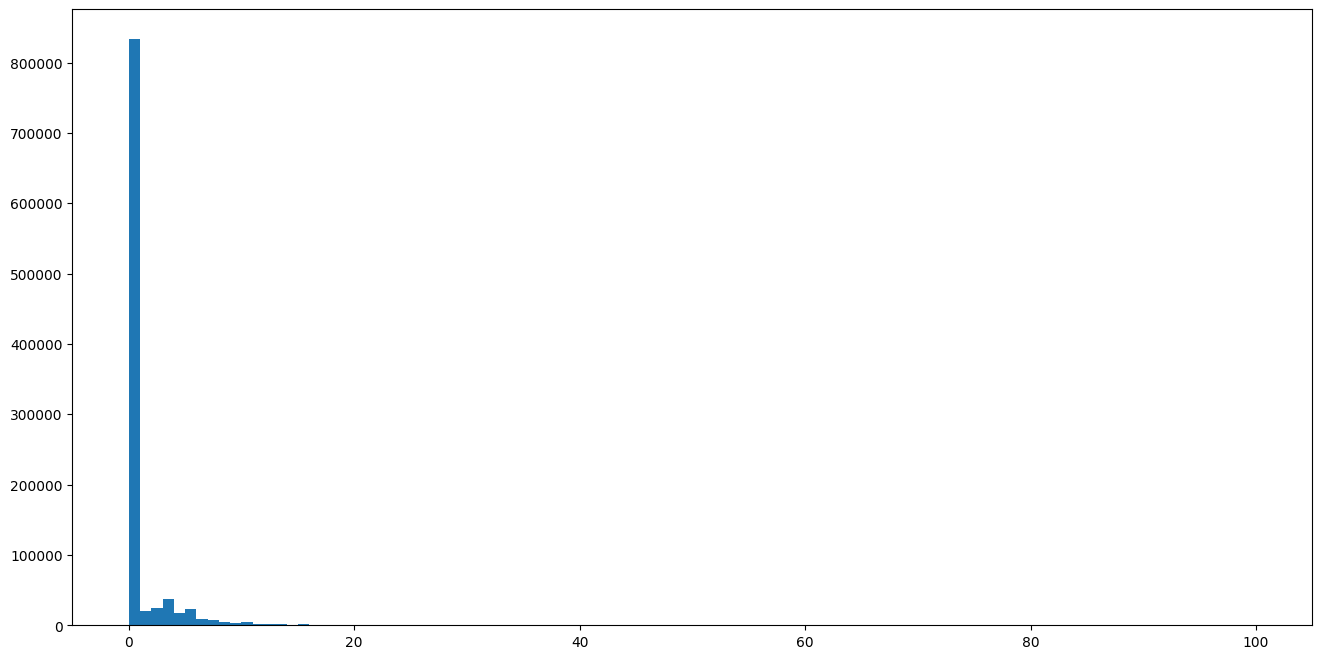

In [57]:
lower_limit, upper_limit = determine_outlier_thresholds_iqr(train_df_fhv[['tips']], 'tips')
print(lower_limit, upper_limit)
plt.hist(train_df_fhv[['tips']], bins=100)
plt.show()

In [58]:
train_df_fhv = train_df_fhv[train_df_fhv['tips'] > 0]
train_df_fhv = train_df_fhv[train_df_fhv['tips'].notnull()]

5.122176838287922


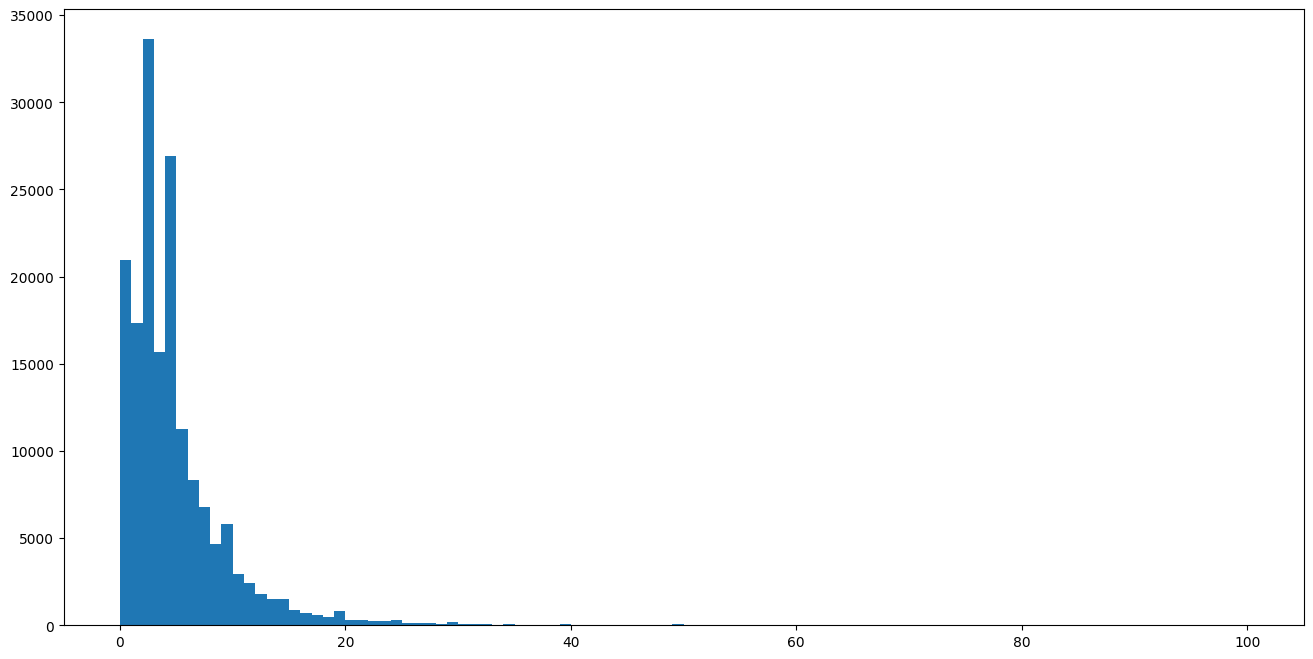

In [59]:
plt.hist(train_df_fhv[['tips']], bins=100)
print(train_df_fhv['tips'].mean())
plt.show()

In [60]:
df_mean_tip_daily_fhv = pd.DataFrame(train_df_fhv['tips'].resample('D').mean())
df_sum_tip_daily_fhv = pd.DataFrame(train_df_fhv['tips'].resample('D').sum())

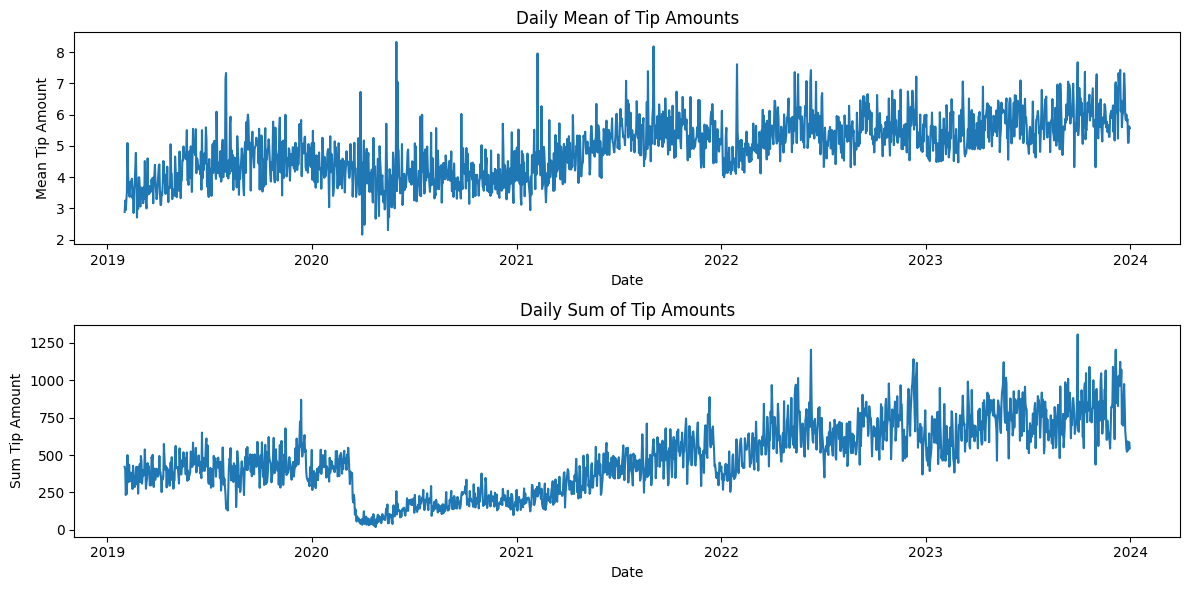

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(df_mean_tip_daily_fhv.index, df_mean_tip_daily_fhv['tips'])
ax[0].set_title('Daily Mean of Tip Amounts')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Tip Amount')

ax[1].plot(df_sum_tip_daily_fhv.index, df_sum_tip_daily_fhv['tips'])
ax[1].set_title('Daily Sum of Tip Amounts')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Sum Tip Amount')

plt.tight_layout()
plt.show()

In [66]:
df_mean_tip_weekly_fhv = pd.DataFrame(train_df_fhv['tips'].resample('W').mean())

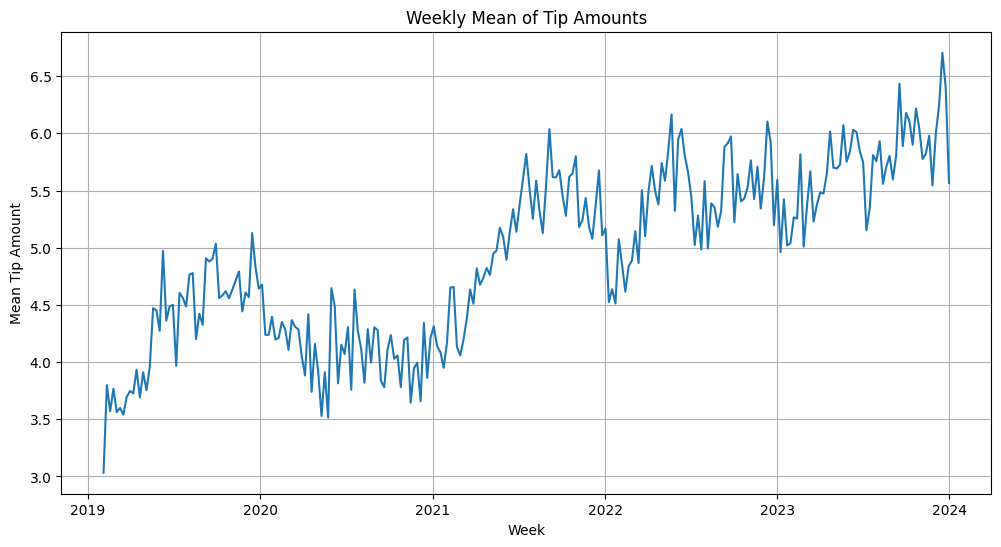

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(df_mean_tip_weekly_fhv.index, df_mean_tip_weekly_fhv['tips'])
plt.title('Weekly Mean of Tip Amounts')
plt.xlabel('Week')
plt.ylabel('Mean Tip Amount')
plt.grid(True)
plt.show()

In [87]:
df_mean_tip_weekly_fhv_2022_2023 = df_mean_tip_weekly_fhv['2022-01':'2023-01']

### Growth

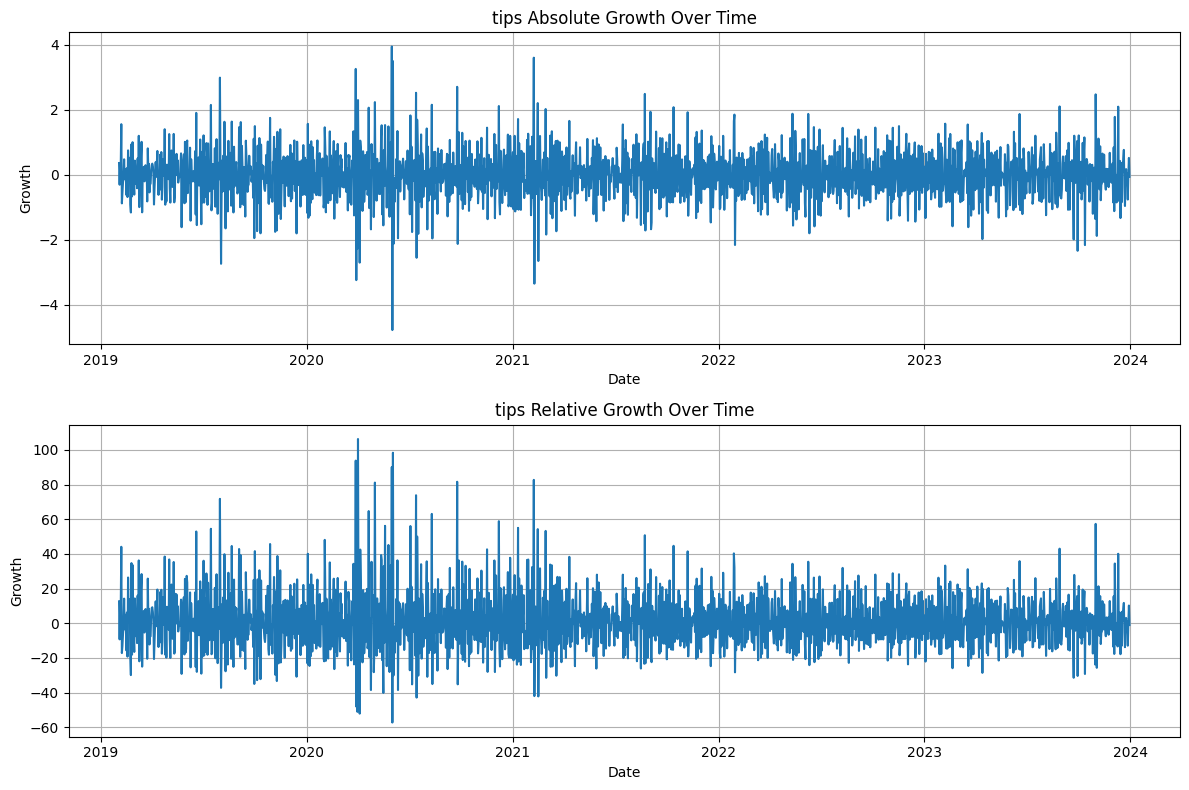

In [68]:
show_growth('tips', df_mean_tip_daily_fhv)

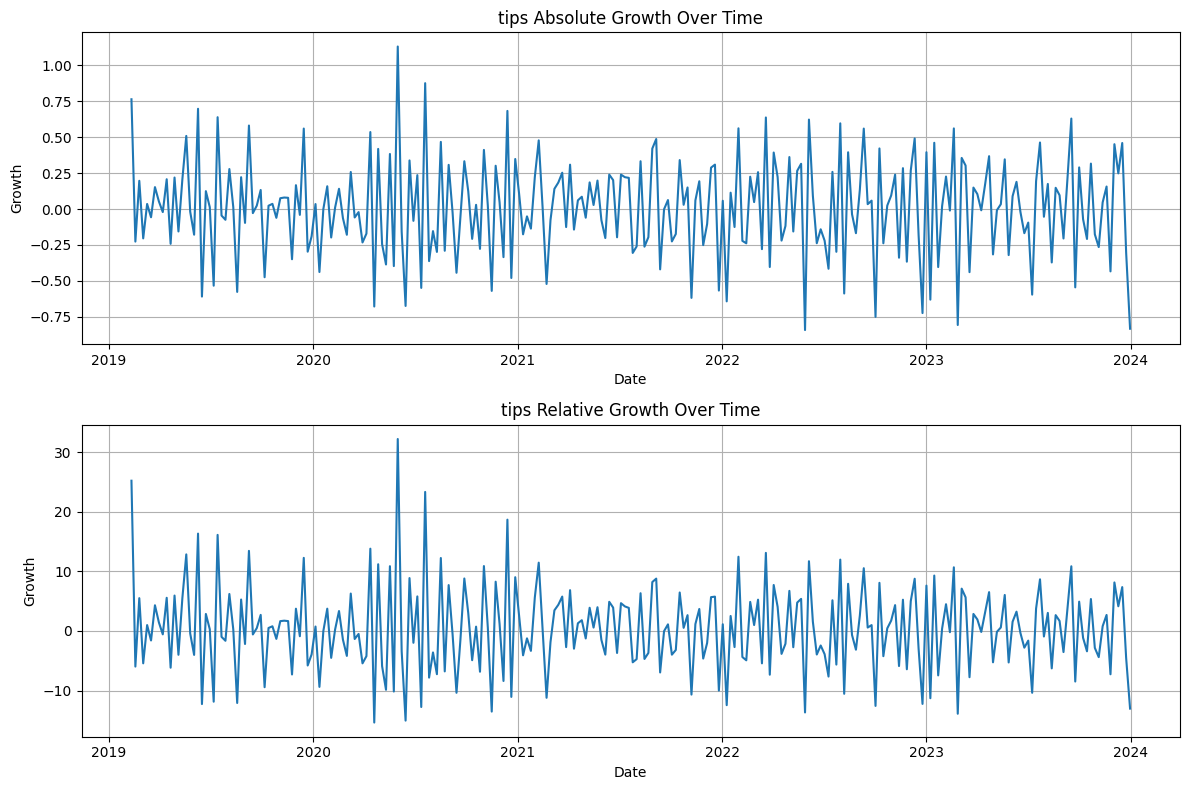

In [69]:
show_growth('tips', df_mean_tip_weekly_fhv)

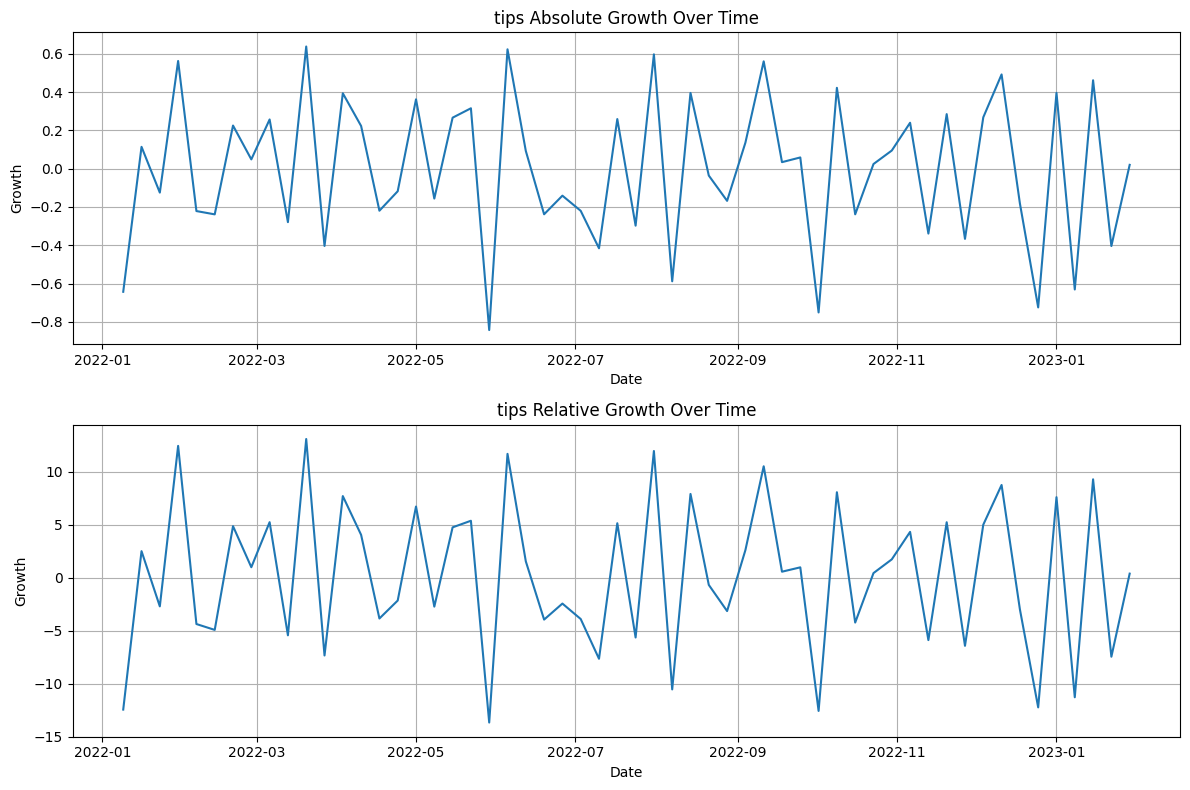

In [88]:
show_growth('tips', df_mean_tip_weekly_fhv_2022_2023)

### Rolling windows

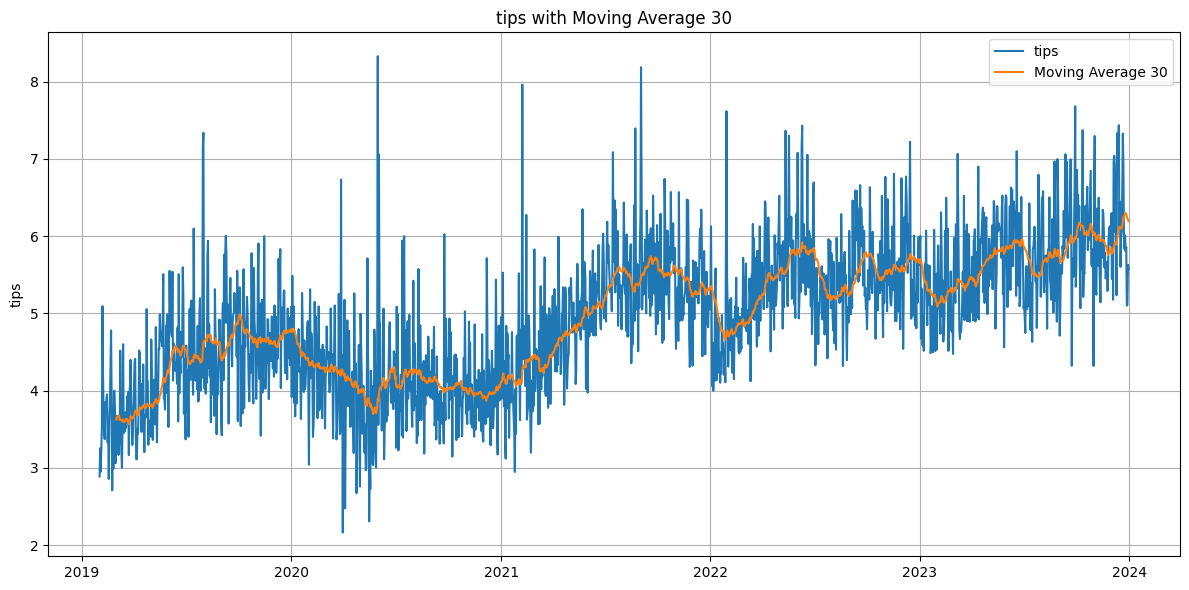

In [70]:
show_windows("tips", df_mean_tip_daily_fhv, [30])

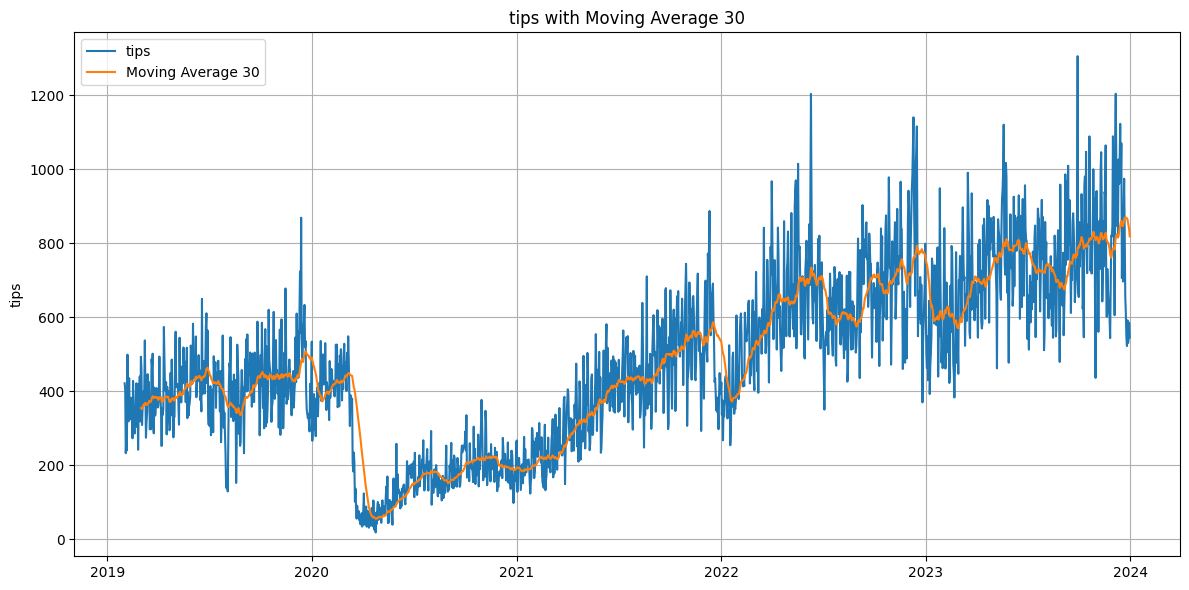

In [71]:
show_windows("tips", df_sum_tip_daily_fhv, [30])

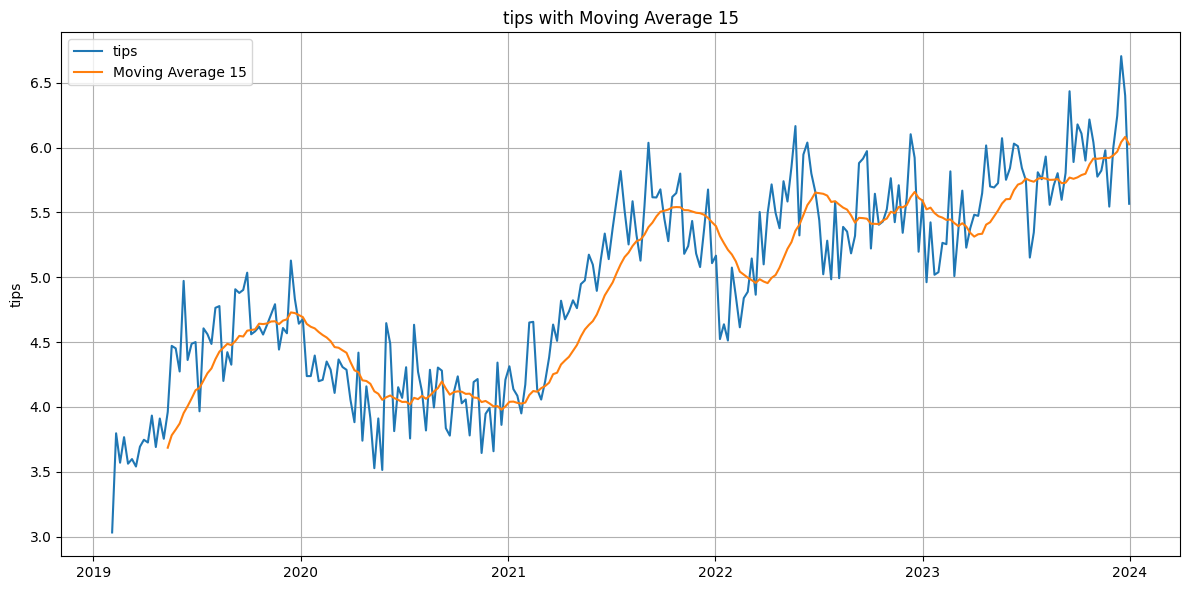

In [72]:
show_windows("tips", df_mean_tip_weekly_fhv, [15])

### Seasonality

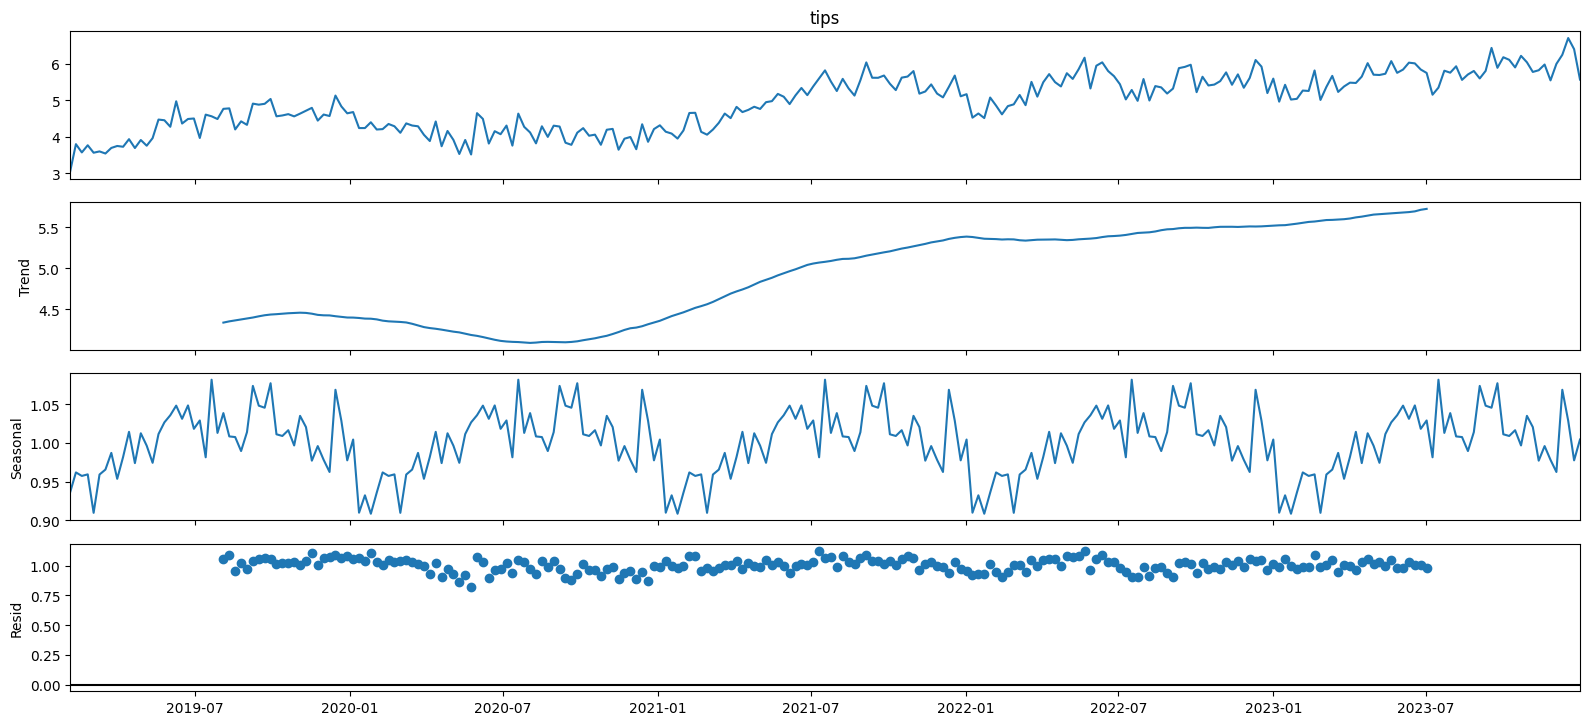

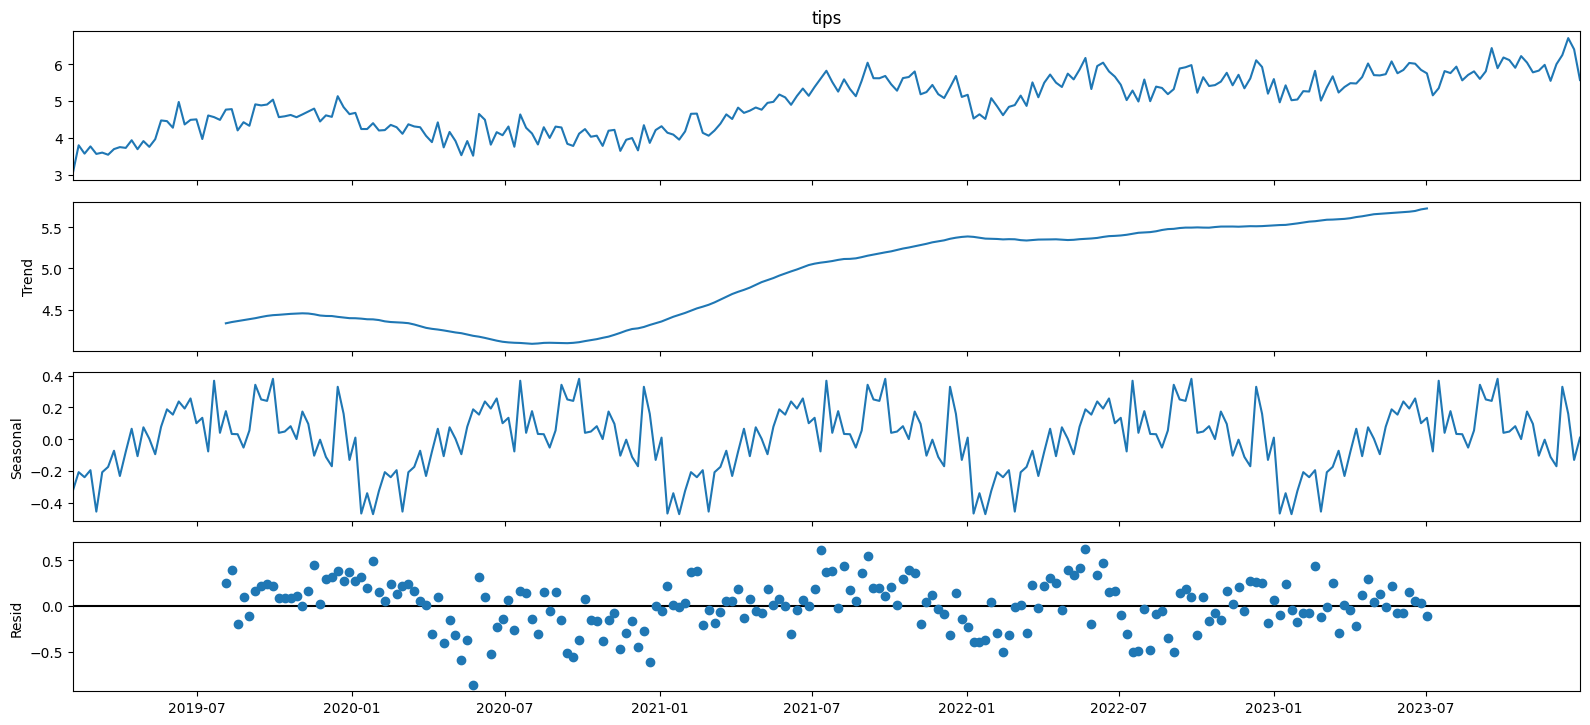

In [73]:
multi_sd_tip_fhv = seasonal_decompose(df_mean_tip_weekly_fhv['tips'], model='multiplicative', period=52)
add_sd_tip_fhv = seasonal_decompose(df_mean_tip_weekly_fhv['tips'], model='additive', period=52)

plt.rcParams.update({'figure.figsize': (16, 8)})
multi_sd_tip_fhv.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

add_sd_tip_fhv.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#### Deseasonlized

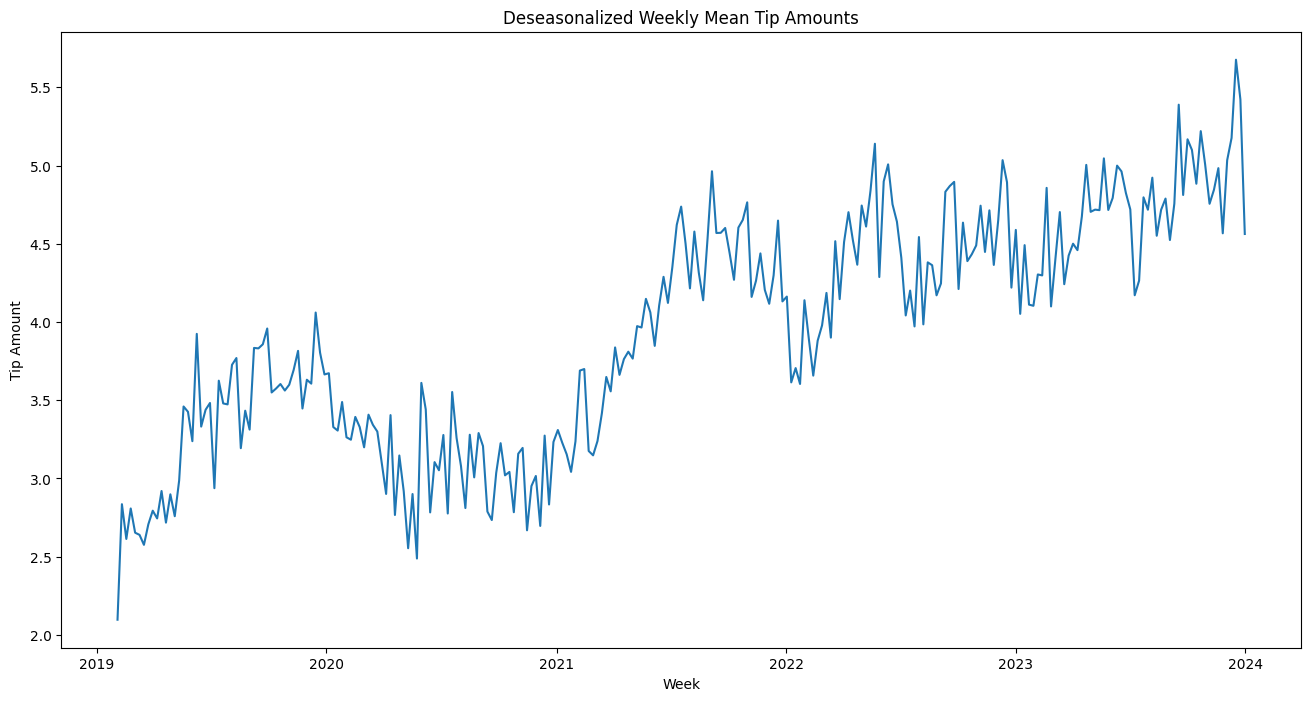

In [74]:
deseas_tip_fhv = df_mean_tip_weekly_fhv['tips'].values - multi_sd_tip_fhv.seasonal
plt.plot(deseas_tip_fhv)
plt.title('Deseasonalized Weekly Mean Tip Amounts')
plt.xlabel('Week')
plt.ylabel('Tip Amount')
plt.show()
